In [1]:
import json
import torch
from torchvision import models, transforms
from PIL import Image
import torchvision.transforms.functional as TF
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import torch.nn.functional as F
# dev for scaling

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

def refine_paths(experiment,args):



    path_list = experiment['train']

    def load_image(filename, crop_size=256, aligned=True, img_size=280):
        img = Image.open(filename)
        img = img.convert('RGB')
        
        if aligned:
            img = TF.resize(img, crop_size, Image.BICUBIC)
            img = TF.to_tensor(img)
            img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        else:
            img = TF.resize(img, img_size, Image.BICUBIC)
            angle = transforms.RandomRotation.get_params([-10, 10])
            img = TF.rotate(img, angle, fill=(0,))
            i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
            img = TF.crop(img, i, j, h, w)
            img = TF.to_tensor(img)
            img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            img = img.to(torch.float32)
        return img

    def embedding_concat(x, y):
        B, C1, H1, W1 = x.size()
        _, C2, H2, W2 = y.size()
        s = int(H1 / H2)
        x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
        x = x.view(B, C1, -1, H2, W2)
        z = torch.zeros(B, C1 + C2, x.size(2), H2, W2).to(device)
        for i in range(x.size(2)):
            z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
        z = z.view(B, -1, H2 * W2)
        z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)
        return z

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    featuremaps = []
    backbone = models.resnet18(pretrained=True).to(device)
    backbone.eval()
    outputs = []

    def hook(module, input, output):
        outputs.append(output)

    backbone.layer1[-1].register_forward_hook(hook)
    backbone.layer2[-1].register_forward_hook(hook)
    backbone.layer3[-1].register_forward_hook(hook)

    img_list = [load_image(path, aligned=False) for path in path_list]

    with torch.no_grad():
        for img in img_list:
            img = img.unsqueeze(0).to(device)
            outputs = []
            _ = backbone(img)
            outputs = embedding_concat(embedding_concat(outputs[0], outputs[1]), outputs[2])
            featuremaps.append(outputs.cpu().numpy())


    shuffled_final = np.array(featuremaps).squeeze()

    isolation_outliers = []
    lof_outliers = []

    for i in range(shuffled_final.shape[1]):
        feature_maps = shuffled_final[:, i, :, :]
        flattened_feature_maps = feature_maps.reshape(feature_maps.shape[0], -1)

        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(flattened_feature_maps)

        clf_isolation = IsolationForest(contamination=args.assumed_contamination_rate)
        outliers_isolation = clf_isolation.fit_predict(features_scaled)
        isolation_outliers.append(outliers_isolation)

        clf_lof = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
        outliers_lof = clf_lof.fit_predict(features_scaled)
        lof_outliers.append(outliers_lof)

    isolation_outliers = np.array(isolation_outliers)
    lof_outliers = np.array(lof_outliers)

    isolation_column_sums = isolation_outliers.sum(axis=0)
    lof_column_sums = lof_outliers.sum(axis=0)


    remove_inds=np.array(lof_column_sums).argsort()[:int(args.assumed_contamination_rate * len(lof_column_sums))]
    selected_paths = [path_list[i] for i in remove_inds]
    refined_paths= [path for path in path_list if path not in selected_paths]

    experiment['isoforest_scores'] = isolation_column_sums.tolist()
    experiment['lof_scores'] = lof_column_sums.tolist()
    experiment['lof_refined_paths'] = refined_paths

    return experiment

    # with open(experiment_path, 'w') as file:
    #     json.dump(experiment, file)
        


def precision_recall(distance_metric: list, groundtruth: list, quantiles: float = 0.001, thresh_larger: bool = False) -> tuple:
    """
    Calculates precision and recall for a given distance metric.
    params: 
        distance_metric: list of distance metric values
        groundtruth: list of groundtruth labels
        quantiles: number of quantiles to calculate precision and recall
        thresh_larger: if True, then the larger the distance_metric the more likely it's a normal sample
    returns: 
        tuple of precision and recall
    """
    quantile_list = np.arange(0, 1, quantiles)
    precision, recall = [], []
    for quantile in quantile_list:
        thresh = np.quantile(distance_metric, quantile)
        predict = np.zeros_like(distance_metric)  # predictions are all normals
        if thresh_larger:
            idxs = np.where(np.array(distance_metric) <= thresh)[0]  # all anomalies
        else:
            idxs = np.where(np.array(distance_metric) >= thresh)[0]  # all anomalies

        predict[idxs] = 1
        tn, fp, fn, tp = confusion_matrix(groundtruth, predict).ravel()

        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
    return precision, recall

def PR_ROC_runs(data_input: dict, category: str):
    plt.figure(figsize=(20, 8))  # Increased figure size for better visibility
    plt.suptitle(f'{category}', y=1.02, fontsize=16)
    
    class_names = []
    data = {}
    
    # Scale all scores in data
    for key in data_input.keys():
        if key not in ['paths', 'gt_labels']:
            class_names.append(key)
            scaled_runs = []
            runs = data_input[key]
            for run in runs:
                if not isinstance(run, np.ndarray):
                    run = np.array(run)
                    
                scaler = MinMaxScaler()
                scores_scaled = scaler.fit_transform(run.reshape(-1, 1)).flatten()
                scaled_runs.append(1 - scores_scaled)
            data[key] = np.array(scaled_runs)
    print(class_names)
            
    colors = ['skyblue','b',  'r', 'c', 'm']


    # Precision-Recall Curve
    plt.subplot(1, 2, 1)
    for class_index, class_name in enumerate(class_names):
        print(class_name)
        scores_list = data[class_name]
        
        # Calculate precision-recall values for each run
        precision_runs = []  # List to store precision values for each run
        recall_runs = [] 
        
        for scores, gt in zip(scores_list, data_input['gt_labels']):
            precision, recall = precision_recall(scores, gt)
            precision_runs.append(precision)
            recall_runs.append(recall)
            
            # plt.plot(recall, precision, color='gray',alpha=0.1)

        precision_mean = np.mean(precision_runs, axis=0)
        recall_mean = np.mean(recall_runs, axis=0)
        
        precision_max = np.max(precision_runs, axis=0)
        precision_min = np.min(precision_runs, axis=0)
        pr_auc = auc(recall, precision)
        
        

        plt.fill_between(recall_mean, precision_min, precision_max, alpha=0.2, color=colors[class_index])
        plt.plot(recall_mean, precision_mean, label=f'{class_name} Mean AUC {pr_auc:.3f}', color=colors[class_index])

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)

    # ROC Curve Subplot
    plt.subplot(1, 2, 2)
    for class_index, class_name in enumerate(class_names):
        scores_list = data[class_name]
        
        # Calculate ROC values for each run
        fprs = []
        tprs = []
        roc_aucs = []

        for scores, gt in zip(scores_list, data_input['gt_labels']):
            fpr, tpr, _ = roc_curve(gt, scores)
            plt.plot(fpr, tpr, color='gray', alpha=0.2)
            
            fprs.append(np.interp(np.linspace(0, 1, 1000), fpr, tpr))  # Interpolating to have the same fpr points
            roc_aucs.append(auc(fpr, tpr))

        fprs = np.array(fprs)

        # Calculate max, min, and median tpr at each fpr point
        tpr_max = np.max(fprs, axis=0)
        tpr_min = np.min(fprs, axis=0)
        tpr_median = np.median(fprs, axis=0)
        fpr_points = np.linspace(0, 1, 1000)
        
        rocauc=auc(fpr, tpr)
        plt.fill_between(fpr_points, tpr_min, tpr_max, alpha=0.1, color=colors[class_index])
        plt.plot(fpr_points, tpr_median, label=f'{class_name} Mean AUC {rocauc:.3f}', color=colors[class_index])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

    # Adjust layout to add space between subplots
    plt.subplots_adjust(wspace=0.3)  # Adjust the space between subplots

    plt.show()
    
    
#original

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.metrics import confusion_matrix

def metrics_and_plots(labels, scores1, scores2, scores3, category):
    scores_list = [scores1, scores2, scores3]
    colors = ['blue', 'green', 'red']
    labels_scores = ['Iso-Forest', 'LOF', 'Ensemble']

    plt.figure(figsize=(24, 6))
    plt.suptitle(f'{category}', y=1.02, fontsize=16) 

    # Plot Precision-Recall curves
    plt.subplot(1, 3, 1)
    for scores, color, label in zip(scores_list, colors, labels_scores):
        scaler = MinMaxScaler()
        scores_scaled = scaler.fit_transform(scores.reshape(-1, 1)).flatten()
        precision, recall, _ = precision_recall_curve(labels, 1 - scores_scaled)
        avg_precision = average_precision_score(labels, 1 - scores_scaled)
        plt.plot(recall, precision, marker='.', color=color, label=f'{label} (AP = {avg_precision:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)

    # Plot ROC curves
    plt.subplot(1, 3, 2)
    for scores, color, label in zip(scores_list, colors, labels_scores):
        scaler = MinMaxScaler()
        scores_scaled = scaler.fit_transform(scores.reshape(-1, 1)).flatten()
        fpr, tpr, _ = roc_curve(labels, 1 - scores_scaled)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, marker='.', color=color, label=f'{label} (AUC = {roc_auc:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

    # Plot FNR vs Threshold
    plt.subplot(1, 3, 3)
    
    for scores, color, label in zip(scores_list, colors, labels_scores):
        scaler = MinMaxScaler()
        scores_scaled = scaler.fit_transform(scores.reshape(-1, 1)).flatten()
        
        indsort=scores_scaled.argsort()
        sorted=scores_scaled[indsort]
        sorted_labs=np.array(labels)[indsort]

        fnr_values = []
        fpr_values = []

        # Calculate FNR for each quantile from 1 to 100
        for q in range(0, 102,2):
            threshold = np.percentile(sorted, q)
            predictions = (sorted <= threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(1-sorted_labs, 1-predictions).ravel()
            # Calculate FNR
            fnr = fn / (tn+fn) if (tn+fn)> 0 else 0
            fnr_values.append(fnr)
            
            fpr = fp / (tn+fp) if (tn+fp)> 0 else 0
            fpr_values.append(fpr)

        # plt.plot(range(0, 102,2), fnr_values, marker='o',color=color)
        plt.plot(range(0, 102,2), fpr_values, marker='o',color=color)
    plt.title('False Negative Ratio (FNR) by Percentile')
    plt.xlabel('Percentile')
    plt.ylabel('False Negative Ratio (FNR)')
    plt.grid(True)
    plt.show()
        

    # Plot histograms of scaled scores
    plt.figure(figsize=(18, 6))
    plt.suptitle(f'{category}', y=1.02, fontsize=16) 
    for i, (scores, color, label) in enumerate(zip(scores_list, colors, labels_scores)):
        plt.subplot(1, 3, i+1)
        scaler = MinMaxScaler()
        scores_scaled = scaler.fit_transform(scores.reshape(-1, 1)).flatten()
        scores_scaled_0 = scores_scaled[labels == 0]
        scores_scaled_1 = scores_scaled[labels == 1]
        plt.hist(scores_scaled_0, bins=30, color='blue', edgecolor='black', alpha=0.7, label='Normals')
        plt.hist(scores_scaled_1, bins=30, color='green', edgecolor='black', alpha=0.7, label='Anomalies')
        plt.title(f'Distribution of {label}')
        plt.xlabel('Score')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    # Creating a bar plot for Scores 1, Scores 2, and Scores 3
    plt.figure(figsize=(30, 6))
    x = np.arange(len(scores1))
    width = 0.2

    plt.bar(x - width, scores1, width, label='Iso-Forest', color='blue')
    plt.bar(x, scores2, width, label='LOF', color='green')
    # plt.bar(x + width, scores3, width, label='Ensemble', color='red')

    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Bar Plot of Scores')
    plt.legend()
    plt.show()
    
def load_image(filename, crop_size=256, aligned=True, img_size=280):
    img = Image.open(filename)
    img = img.convert('RGB')
    
    if aligned:
        img = TF.resize(img, crop_size, Image.BICUBIC)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    else:
        img = TF.resize(img, img_size, Image.BICUBIC)
        angle = transforms.RandomRotation.get_params([-10, 10])
        img = TF.rotate(img, angle, fill=(0,))
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
        img = TF.crop(img, i, j, h, w)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img = img.to(torch.float32)
    return img

In [7]:
import pickle

# Specify the file path where you want to save the pickle file
file_path = '/home/bule/projects/UTRAD/LOF_ISO_togheter.pkl'

# Open the file in write mode and save the data as a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(data, file)

['own; ISO ', 'own; LOF', 'TSNE; ISO', 'TSNE; LOF', 'PCA; ISO', 'PCA; LOF', 'Original; ISO', 'Original; LOF']
own; ISO 


InvalidParameterError: The 'y_true' parameter of confusion_matrix must be an array-like. Got 0 instead.

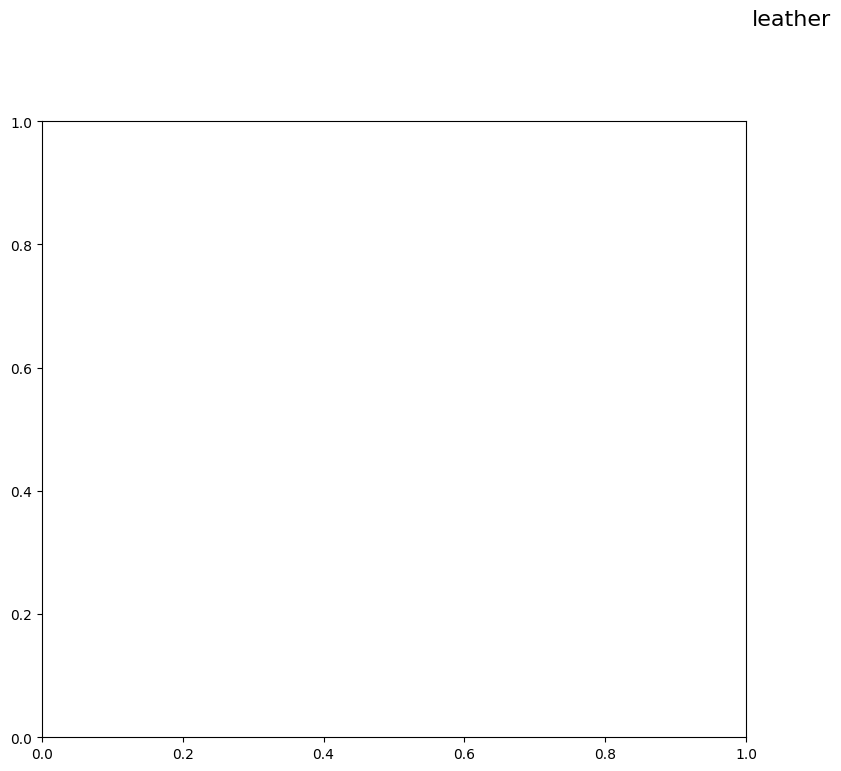

In [8]:
import pickle

file_path = '/home/bule/projects/UTRAD/LOF_ISO_togheter.pkl'

with open(file_path, 'rb') as file:
    input_= pickle.load(file)

PR_ROC_runs(data_input=input_, category="leather")

In [5]:
import torch
import json
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Define the TrainOptions class
class TrainOptions:
    def __init__(self, category):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

# Initialize the options
category = "leather"
args = TrainOptions(category)

data = {}
paths=[f'/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_{i}-leather/experiment_paths.json' for i in range(1,6)]

for path in paths:
     with open(path, 'r') as file:
          experiment = json.load(file)

     ############################################################################## OWN REFINEMENT FUNCTION
     experiment_refined=refine_paths(experiment,args) 
     labels=[0 if 'good' in path else 1 for path in experiment_refined['train']]

     data['paths']=experiment_refined['train']
     data['gt_labels']=labels
     data['own; ISO ']=np.array(experiment_refined['isoforest_scores'])
     data['own; LOF']=np.array(experiment_refined['lof_scores'])
     
     ############################################################################ ON ORIGINAL IMAGE DATA PCA AND TSNE LOF AND ISO
     
     img_list = [load_image(path, aligned=False) for path in experiment_refined['train']]
     img_array = np.array([img.numpy().flatten() for img in img_list])

     # Apply PCA and t-SNE
     pca = PCA(n_components=2, random_state=args.seed)
     pca_results = pca.fit_transform(img_array)

     tsne = TSNE(n_components=2, random_state=args.seed)
     tsne_results = tsne.fit_transform(img_array)

     # Apply LOF and Isolation Forest for anomaly detection on PCA results
     lof_pca = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
     lof_pca_preds = lof_pca.fit_predict(pca_results)

     isf_pca = IsolationForest(contamination=args.assumed_contamination_rate, random_state=args.seed)
     isf_pca.fit(pca_results)
     isf_pca_preds = isf_pca.predict(pca_results)

     # Apply LOF and Isolation Forest for anomaly detection on t-SNE results
     lof_tsne = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
     lof_tsne_preds = lof_tsne.fit_predict(tsne_results)

     isf_tsne = IsolationForest(contamination=args.assumed_contamination_rate, random_state=args.seed)
     isf_tsne.fit(tsne_results)
     isf_tsne_preds = isf_tsne.predict(tsne_results)
     
     data['TSNE; ISO']=np.array(isf_tsne_preds)
     data['TSNE; LOF']=np.array(lof_tsne_preds)
     data['PCA; ISO']=np.array(isf_pca_preds)
     data['PCA; LOF']=np.array(lof_pca_preds)
     
     
     #############################################################################
     lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
     lof_pred = lof.fit_predict(img_array)

     
     data['Original; ISO']=np.array(isf_tsne_preds)
     data['Original; LOF']=np.array(lof_tsne_preds)
     
     print('run done')
     

run done


/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


run done


/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


run done


/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


run done


/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


run done


In [6]:
data

{'paths': ['/home/bule/projects/datasets/mvtec_anomaly_detection/leather/train/good/028.png',
  '/home/bule/projects/datasets/mvtec_anomaly_detection/leather/train/good/095.png',
  '/home/bule/projects/datasets/mvtec_anomaly_detection/leather/train/good/078.png',
  '/home/bule/projects/datasets/mvtec_anomaly_detection/leather/train/good/064.png',
  '/home/bule/projects/datasets/mvtec_anomaly_detection/leather/train/good/172.png',
  '/home/bule/projects/datasets/mvtec_anomaly_detection/leather/train/good/243.png',
  '/home/bule/projects/datasets/mvtec_anomaly_detection/leather/train/good/202.png',
  '/home/bule/projects/datasets/mvtec_anomaly_detection/leather/train/good/174.png',
  '/home/bule/projects/datasets/mvtec_anomaly_detection/leather/test/cut/016.png',
  '/home/bule/projects/datasets/mvtec_anomaly_detection/leather/train/good/044.png',
  '/home/bule/projects/datasets/mvtec_anomaly_detection/leather/test/poke/008.png',
  '/home/bule/projects/datasets/mvtec_anomaly_detection/lea

### Examples on diff classes

PCA + LOF:
               precision    recall  f1-score   support

        Good       0.93      0.90      0.92       245
     Anomaly       0.11      0.15      0.13        20

    accuracy                           0.85       265
   macro avg       0.52      0.53      0.52       265
weighted avg       0.87      0.85      0.86       265

PCA + Isolation Forest:
               precision    recall  f1-score   support

        Good       0.94      0.91      0.93       245
     Anomaly       0.22      0.30      0.26        20

    accuracy                           0.87       265
   macro avg       0.58      0.61      0.59       265
weighted avg       0.89      0.87      0.88       265

t-SNE + LOF:
               precision    recall  f1-score   support

        Good       0.94      0.91      0.93       245
     Anomaly       0.22      0.30      0.26        20

    accuracy                           0.87       265
   macro avg       0.58      0.61      0.59       265
weighted avg       0.89

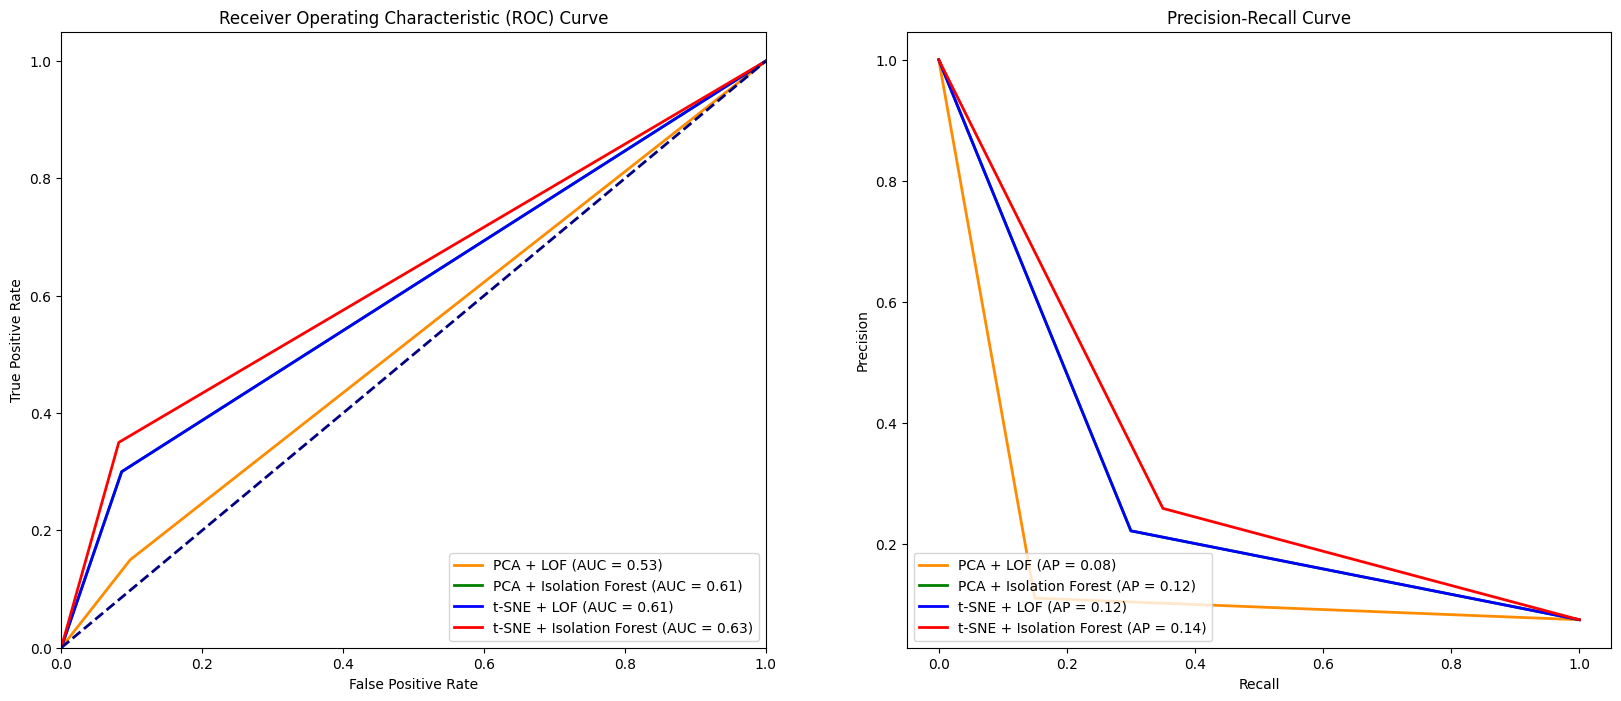

In [184]:
import torch
import json
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Define the TrainOptions class
class TrainOptions:
    def __init__(self, category):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

# Initialize the options
category = "leather"
args = TrainOptions(category)
torch.manual_seed(args.seed)

# Load the experiment paths
experiment_path = '/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_1-leather/experiment_paths.json'
with open(experiment_path, 'r') as file:
    experiment = json.load(file)

# Get the list of training image paths
path_list = experiment['train']

# Define the image loading function
def load_image(filename, crop_size=256, aligned=True, img_size=280):
    img = Image.open(filename)
    img = img.convert('RGB')
    
    if aligned:
        img = TF.resize(img, crop_size, Image.BICUBIC)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    else:
        img = TF.resize(img, img_size, Image.BICUBIC)
        angle = transforms.RandomRotation.get_params([-10, 10])
        img = TF.rotate(img, angle, fill=(0,))
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
        img = TF.crop(img, i, j, h, w)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img = img.to(torch.float32)
    return img

# Load and preprocess the images
img_list = [load_image(path, aligned=False) for path in path_list]

# Create labels (0 for 'good', 1 for 'anomaly')
labels = [0 if 'good' in path else 1 for path in experiment['train']]

# Convert the image list to a numpy array for dimensionality reduction
img_array = np.array([img.numpy().flatten() for img in img_list])

# Apply PCA and t-SNE
pca = PCA(n_components=2, random_state=args.seed)
pca_results = pca.fit_transform(img_array)

tsne = TSNE(n_components=2, random_state=args.seed)
tsne_results = tsne.fit_transform(img_array)

# Apply LOF and Isolation Forest for anomaly detection on PCA results
lof_pca = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
lof_pca_preds = lof_pca.fit_predict(pca_results)
lof_pca_labels = (lof_pca_preds == -1).astype(int)  # 1 for anomalies, 0 for normal instances

isf_pca = IsolationForest(contamination=args.assumed_contamination_rate, random_state=args.seed)
isf_pca.fit(pca_results)
isf_pca_labels = isf_pca.predict(pca_results)
isf_pca_labels = (isf_pca_labels == -1).astype(int)  # 1 for anomalies, 0 for normal instances

# Apply LOF and Isolation Forest for anomaly detection on t-SNE results
lof_tsne = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
lof_tsne_preds = lof_tsne.fit_predict(tsne_results)
lof_tsne_labels = (lof_tsne_preds == -1).astype(int)  # 1 for anomalies, 0 for normal instances

isf_tsne = IsolationForest(contamination=args.assumed_contamination_rate, random_state=args.seed)
isf_tsne.fit(tsne_results)
isf_tsne_labels = isf_tsne.predict(tsne_results)
isf_tsne_labels = (isf_tsne_labels == -1).astype(int)  # 1 for anomalies, 0 for normal instances

# Generate classification reports
report_pca_lof = classification_report(labels, lof_pca_labels, target_names=['Good', 'Anomaly'])
report_pca_isf = classification_report(labels, isf_pca_labels, target_names=['Good', 'Anomaly'])
report_tsne_lof = classification_report(labels, lof_tsne_labels, target_names=['Good', 'Anomaly'])
report_tsne_isf = classification_report(labels, isf_tsne_labels, target_names=['Good', 'Anomaly'])

print("PCA + LOF:\n", report_pca_lof)
print("PCA + Isolation Forest:\n", report_pca_isf)
print("t-SNE + LOF:\n", report_tsne_lof)
print("t-SNE + Isolation Forest:\n", report_tsne_isf)

# Compute ROC curve and ROC area for each method
fpr_pca_lof, tpr_pca_lof, _ = roc_curve(labels, lof_pca_labels)
roc_auc_pca_lof = auc(fpr_pca_lof, tpr_pca_lof)

fpr_pca_isf, tpr_pca_isf, _ = roc_curve(labels, isf_pca_labels)
roc_auc_pca_isf = auc(fpr_pca_isf, tpr_pca_isf)

fpr_tsne_lof, tpr_tsne_lof, _ = roc_curve(labels, lof_tsne_labels)
roc_auc_tsne_lof = auc(fpr_tsne_lof, tpr_tsne_lof)

fpr_tsne_isf, tpr_tsne_isf, _ = roc_curve(labels, isf_tsne_labels)
roc_auc_tsne_isf = auc(fpr_tsne_isf, tpr_tsne_isf)

# Compute Precision-Recall curve and average precision for each method
precision_pca_lof, recall_pca_lof, _ = precision_recall_curve(labels, lof_pca_labels)
average_precision_pca_lof = average_precision_score(labels, lof_pca_labels)

precision_pca_isf, recall_pca_isf, _ = precision_recall_curve(labels, isf_pca_labels)
average_precision_pca_isf = average_precision_score(labels, isf_pca_labels)

precision_tsne_lof, recall_tsne_lof, _ = precision_recall_curve(labels, lof_tsne_labels)
average_precision_tsne_lof = average_precision_score(labels, lof_tsne_labels)

precision_tsne_isf, recall_tsne_isf, _ = precision_recall_curve(labels, isf_tsne_labels)
average_precision_tsne_isf = average_precision_score(labels, isf_tsne_labels)

# Plot ROC and Precision-Recall curves side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# ROC curve
ax1.plot(fpr_pca_lof, tpr_pca_lof, color='darkorange', lw=2, label=f'PCA + LOF (AUC = {roc_auc_pca_lof:.2f})')
ax1.plot(fpr_pca_isf, tpr_pca_isf, color='green', lw=2, label=f'PCA + Isolation Forest (AUC = {roc_auc_pca_isf:.2f})')
ax1.plot(fpr_tsne_lof, tpr_tsne_lof, color='blue', lw=2, label=f't-SNE + LOF (AUC = {roc_auc_tsne_lof:.2f})')
ax1.plot(fpr_tsne_isf, tpr_tsne_isf, color='red', lw=2, label=f't-SNE + Isolation Forest (AUC = {roc_auc_tsne_isf:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend(loc="lower right")

# Precision-Recall curve
ax2.plot(recall_pca_lof, precision_pca_lof, color='darkorange', lw=2, label=f'PCA + LOF (AP = {average_precision_pca_lof:.2f})')
ax2.plot(recall_pca_isf, precision_pca_isf, color='green', lw=2, label=f'PCA + Isolation Forest (AP = {average_precision_pca_isf:.2f})')
ax2.plot(recall_tsne_lof, precision_tsne_lof, color='blue', lw=2, label=f't-SNE + LOF (AP = {average_precision_tsne_lof:.2f})')
ax2.plot(recall_tsne_isf, precision_tsne_isf, color='red', lw=2, label=f't-SNE + Isolation Forest (AP = {average_precision_tsne_isf:.2f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left")

plt.show()


(265, 196608)


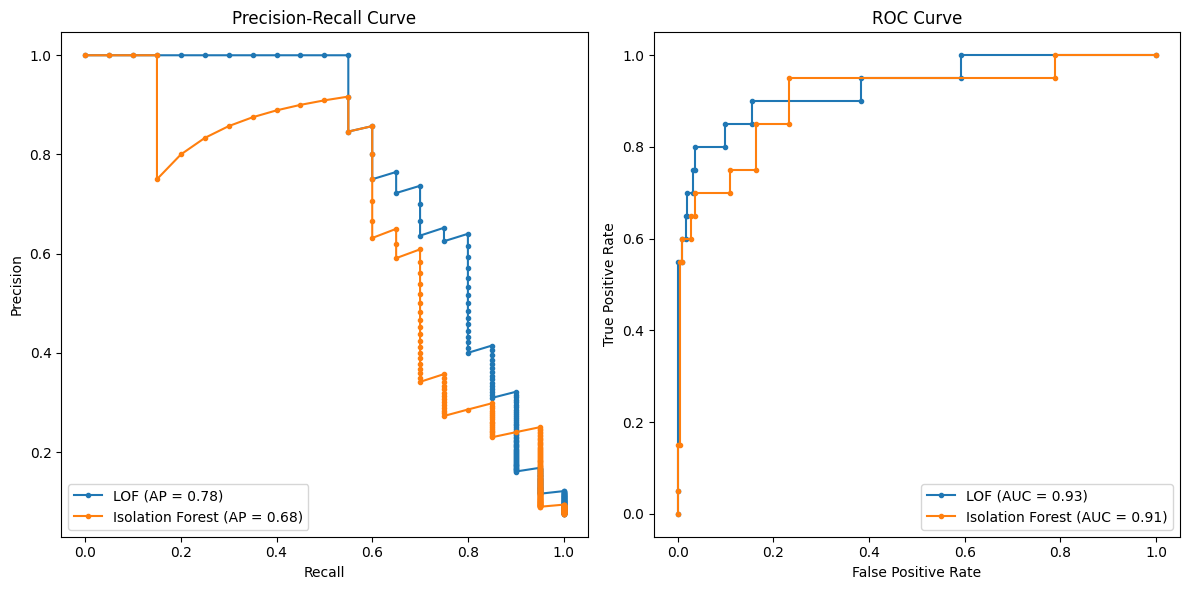

In [6]:
import torch
import json
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Define the TrainOptions class
class TrainOptions:
    def __init__(self, category):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

# Initialize the options
category = "leather"
args = TrainOptions(category)
torch.manual_seed(args.seed)

# Load the experiment paths
experiment_path = '/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_1-leather/experiment_paths.json'
with open(experiment_path, 'r') as file:
    experiment = json.load(file)

# Get the list of training image paths
path_list = experiment['train']

# Define the image loading function
def load_image(filename, crop_size=256, aligned=True, img_size=280):
    img = Image.open(filename)
    img = img.convert('RGB')
    
    if aligned:
        img = TF.resize(img, crop_size, Image.BICUBIC)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    else:
        img = TF.resize(img, img_size, Image.BICUBIC)
        angle = transforms.RandomRotation.get_params([-10, 10])
        img = TF.rotate(img, angle, fill=(0,))
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
        img = TF.crop(img, i, j, h, w)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img = img.to(torch.float32)
    return img

# Load and preprocess the images
img_list = [load_image(path, aligned=False) for path in path_list]

# Create labels (0 for 'good', 1 for 'anomaly')
labels = [0 if 'good' in path else 1 for path in experiment['train']]

# Convert the image list to a numpy array for dimensionality reduction
img_array = np.array([img.numpy().flatten() for img in img_list])
print(img_array.shape)
# LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof_pred = lof.fit_predict(img_array)
lof_scores = -lof.negative_outlier_factor_

# Convert LOF output to binary labels: -1 for outliers becomes 1 (anomaly), 1 for inliers becomes 0 (good)
lof_pred = np.where(lof_pred == -1, 1, 0)

# Compute precision-recall curve and average precision score for LOF
lof_precision, lof_recall, _ = precision_recall_curve(labels, lof_scores)
lof_average_precision = average_precision_score(labels, lof_scores)

# Compute ROC curve and ROC AUC for LOF
lof_fpr, lof_tpr, _ = roc_curve(labels, lof_scores)
lof_roc_auc = auc(lof_fpr, lof_tpr)

# Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=args.seed)
iso_forest.fit(img_array)
iso_scores = -iso_forest.decision_function(img_array)
iso_pred = iso_forest.predict(img_array)

# Convert Isolation Forest output to binary labels: -1 for outliers becomes 1 (anomaly), 1 for inliers becomes 0 (good)
iso_pred = np.where(iso_pred == -1, 1, 0)

# Compute precision-recall curve and average precision score for Isolation Forest
iso_precision, iso_recall, _ = precision_recall_curve(labels, iso_scores)
iso_average_precision = average_precision_score(labels, iso_scores)

# Compute ROC curve and ROC AUC for Isolation Forest
iso_fpr, iso_tpr, _ = roc_curve(labels, iso_scores)
iso_roc_auc = auc(iso_fpr, iso_tpr)

# Plot the precision-recall curve and ROC curve side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Precision-Recall curve
ax1.plot(lof_recall, lof_precision, marker='.', label=f'LOF (AP = {lof_average_precision:.2f})')
ax1.plot(iso_recall, iso_precision, marker='.', label=f'Isolation Forest (AP = {iso_average_precision:.2f})')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve')
ax1.legend()

# ROC curve
ax2.plot(lof_fpr, lof_tpr, marker='.', label=f'LOF (AUC = {lof_roc_auc:.2f})')
ax2.plot(iso_fpr, iso_tpr, marker='.', label=f'Isolation Forest (AUC = {iso_roc_auc:.2f})')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()


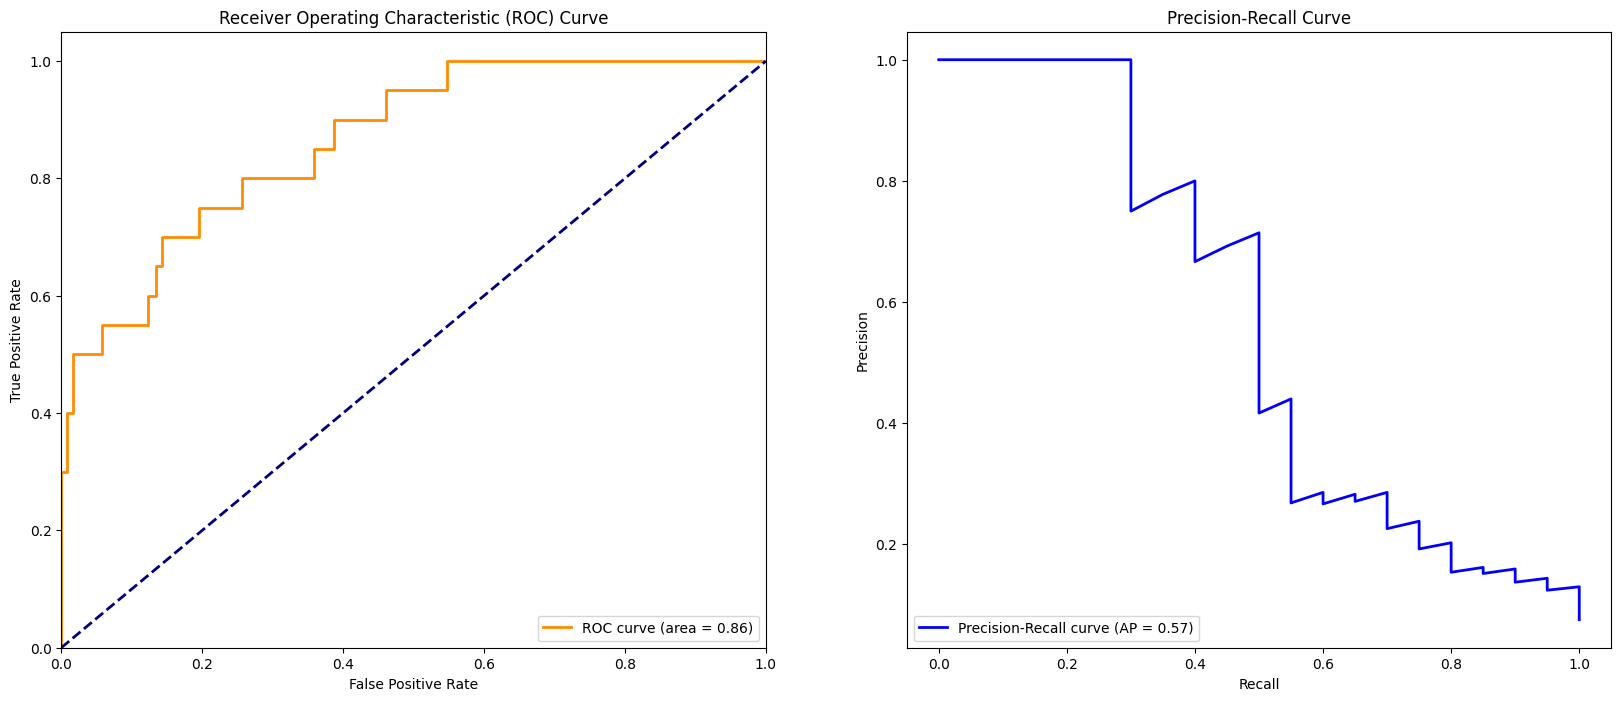

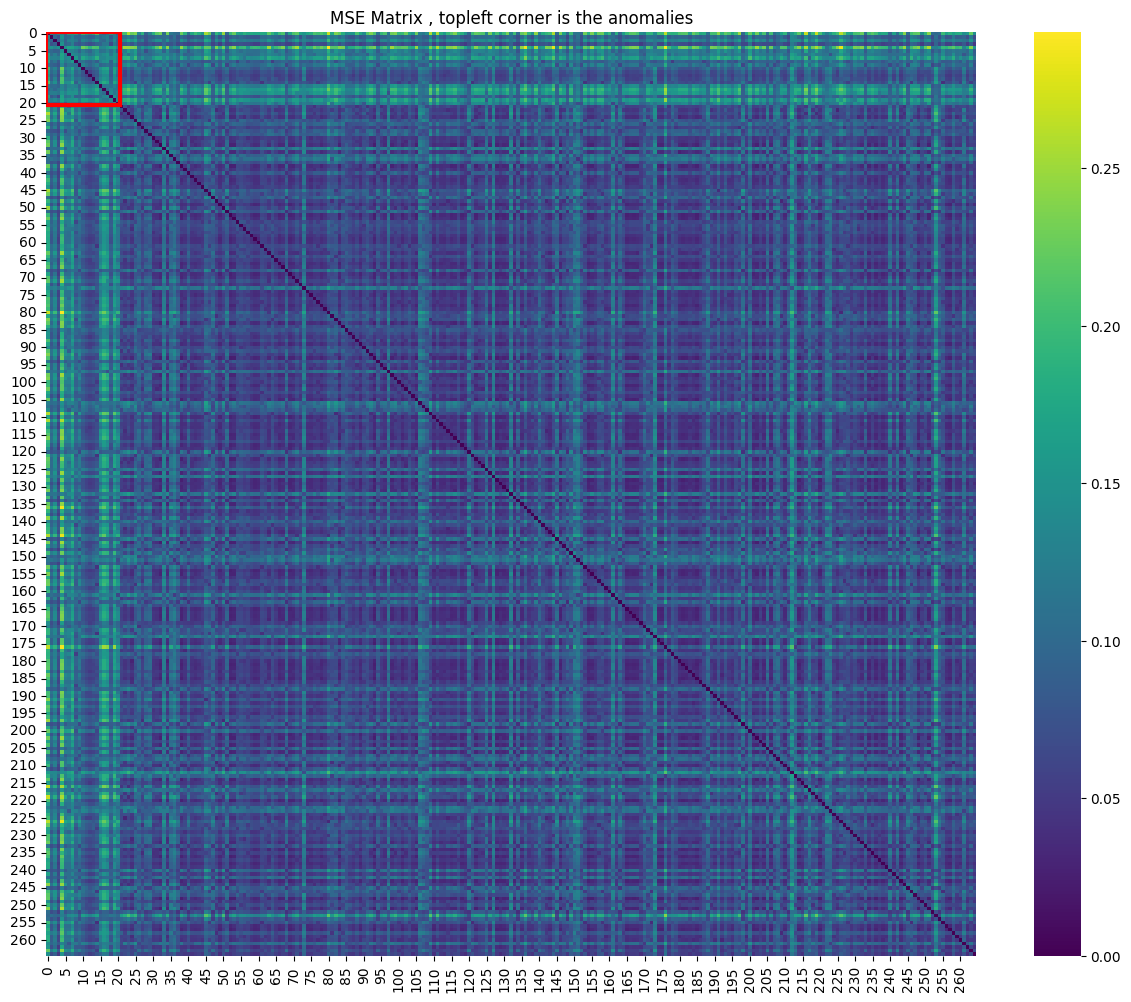

In [10]:
################ Only MSE

import torch
import json
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the TrainOptions class
class TrainOptions:
    def __init__(self, category):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

# Initialize the options
category = "leather"
args = TrainOptions(category)
torch.manual_seed(args.seed)

# Load the experiment paths
experiment_path = '/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_1-leather/experiment_paths.json'
with open(experiment_path, 'r') as file:
    experiment = json.load(file)

# Get the list of training image paths
path_list = experiment['train']

# Define the image loading function
def load_image(filename, crop_size=256, aligned=True, img_size=280):
    img = Image.open(filename)
    img = img.convert('RGB')
    
    if aligned:
        img = TF.resize(img, crop_size, Image.BICUBIC)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    else:
        img = TF.resize(img, img_size, Image.BICUBIC)
        angle = transforms.RandomRotation.get_params([-10, 10])
        img = TF.rotate(img, angle, fill=(0,))
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
        img = TF.crop(img, i, j, h, w)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img = img.to(torch.float32)
    return img

# Load and preprocess the images
img_list = [load_image(path, aligned=False) for path in path_list]

# Function to compute MSE between two images
def compute_mse(img1, img2):
    return mean_squared_error(img1.numpy().flatten(), img2.numpy().flatten())

# Create an empty matrix to store MSE values
mse_matrix = np.zeros((len(img_list), len(img_list)))

# Calculate the MSE between each pair of images
for i in range(len(img_list)):
    for j in range(len(img_list)):
        mse_matrix[i, j] = compute_mse(img_list[i], img_list[j])


# Get true labels
labels = np.array([0 if 'good' in path else 1 for path in experiment['train']])

# Calculate column sums of the MSE matrix
col_sums = np.sum(mse_matrix, axis=0)

# Sort the column sums and labels
indexes = np.argsort(col_sums)
colsums_sorted = col_sums[indexes]
labels_sorted = labels[indexes]

# Normalize the sorted column sums
scaler = MinMaxScaler()
colsums_sorted = scaler.fit_transform(colsums_sorted.reshape(-1, 1)).flatten()

# Calculate precision, recall, and ROC AUC
precision, recall, _ = precision_recall_curve(labels_sorted, colsums_sorted)
average_precision = average_precision_score(labels_sorted, colsums_sorted)
fpr, tpr, _ = roc_curve(labels_sorted, colsums_sorted)
roc_auc = auc(fpr, tpr)

# Plot ROC curve and Precision-Recall curve side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# ROC curve
ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[0].legend(loc="lower right")

# Precision-Recall curve
ax[1].plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve')
ax[1].legend(loc="lower left")

plt.show()

indexes_1 = np.where(labels == 1)[0]
indexes_0 = np.where(labels == 0)[0]
index_conc=np.concatenate((indexes_1,indexes_0))
index_conc



img_list_reorder=[img_list[i] for i in index_conc]
# Create an empty matrix to store MSE values
mse_matrix_2 = np.zeros((len(img_list_reorder), len(img_list_reorder)))

# Calculate the MSE between each pair of images
for i in range(len(img_list_reorder)):
    for j in range(len(img_list_reorder)):
        mse_matrix_2[i, j] = compute_mse(img_list_reorder[i], img_list_reorder[j])


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches


# Create a heatmap
plt.figure(figsize=(15, 12))
ax = sns.heatmap(mse_matrix_2, cmap="viridis")

# Add a square frame to the top-left corner
rect = patches.Rectangle((0, 0), 21, 21, linewidth=3, edgecolor='red', facecolor='none')
ax.add_patch(rect)

# Set the title and labels for the axes
plt.title("MSE Matrix , topleft corner is the anomalies")
plt.show()


In [2]:
experiment_path = '/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_1-leather/experiment_paths.json'
with open(experiment_path, 'r') as file:
    experiment = json.load(file)

# Get the list of training image paths
path_list = experiment['train']


def load_image(filename, crop_size=256, aligned=True, img_size=280):
    img = Image.open(filename)
    img = img.convert('RGB')
    
    if aligned:
        img = TF.resize(img, crop_size, Image.BICUBIC)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    else:
        img = TF.resize(img, img_size, Image.BICUBIC)
        angle = transforms.RandomRotation.get_params([-10, 10])
        img = TF.rotate(img, angle, fill=(0,))
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
        img = TF.crop(img, i, j, h, w)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img = img.to(torch.float32)
    return img

def embedding_concat(x, y):
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()
    s = int(H1 / H2)
    x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
    x = x.view(B, C1, -1, H2, W2)
    z = torch.zeros(B, C1 + C2, x.size(2), H2, W2).to(device)
    for i in range(x.size(2)):
        z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)
    return z

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
featuremaps = []
backbone = models.resnet18(pretrained=True).to(device)
backbone.eval()
outputs = []

def hook(module, input, output):
    outputs.append(output)

backbone.layer1[-1].register_forward_hook(hook)
backbone.layer2[-1].register_forward_hook(hook)
backbone.layer3[-1].register_forward_hook(hook)

img_list = [load_image(path, aligned=False) for path in path_list]

with torch.no_grad():
    for img in img_list:
        img = img.unsqueeze(0).to(device)
        outputs = []
        _ = backbone(img)
        outputs = embedding_concat(embedding_concat(outputs[0], outputs[1]), outputs[2])
        featuremaps.append(outputs.cpu().numpy())


shuffled_final = np.array(featuremaps).squeeze()







/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Convert the image list to a numpy array for dimensionality reduction
img_array = np.array([img.flatten() for img in shuffled_final])
img_array.shape

(265, 1835008)

In [5]:
# LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof_pred = lof.fit_predict(img_array)
lof_scores = -lof.negative_outlier_factor_

# Convert LOF output to binary labels: -1 for outliers becomes 1 (anomaly), 1 for inliers becomes 0 (good)
lof_pred = np.where(lof_pred == -1, 1, 0)

# Compute precision-recall curve and average precision score for LOF
lof_precision, lof_recall, _ = precision_recall_curve(labels, lof_scores)
lof_average_precision = average_precision_score(labels, lof_scores)

# Compute ROC curve and ROC AUC for LOF
lof_fpr, lof_tpr, _ = roc_curve(labels, lof_scores)
lof_roc_auc = auc(lof_fpr, lof_tpr)

# # Isolation Forest
# iso_forest = IsolationForest(contamination=0.1, random_state=args.seed)
# iso_forest.fit(img_array)
# iso_scores = -iso_forest.decision_function(img_array)
# iso_pred = iso_forest.predict(img_array)

# # Convert Isolation Forest output to binary labels: -1 for outliers becomes 1 (anomaly), 1 for inliers becomes 0 (good)
# iso_pred = np.where(iso_pred == -1, 1, 0)

# # Compute precision-recall curve and average precision score for Isolation Forest
# iso_precision, iso_recall, _ = precision_recall_curve(labels, iso_scores)
# iso_average_precision = average_precision_score(labels, iso_scores)

# # Compute ROC curve and ROC AUC for Isolation Forest
# iso_fpr, iso_tpr, _ = roc_curve(labels, iso_scores)
# iso_roc_auc = auc(iso_fpr, iso_tpr)

# Plot the precision-recall curve and ROC curve side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Precision-Recall curve
ax1.plot(lof_recall, lof_precision, marker='.', label=f'LOF (AP = {lof_average_precision:.2f})')
ax1.plot(iso_recall, iso_precision, marker='.', label=f'Isolation Forest (AP = {iso_average_precision:.2f})')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve')
ax1.legend()

# # ROC curve
# ax2.plot(lof_fpr, lof_tpr, marker='.', label=f'LOF (AUC = {lof_roc_auc:.2f})')
# ax2.plot(iso_fpr, iso_tpr, marker='.', label=f'Isolation Forest (AUC = {iso_roc_auc:.2f})')
# ax2.set_xlabel('False Positive Rate')
# ax2.set_ylabel('True Positive Rate')
# ax2.set_title('ROC Curve')
# ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

: 

/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


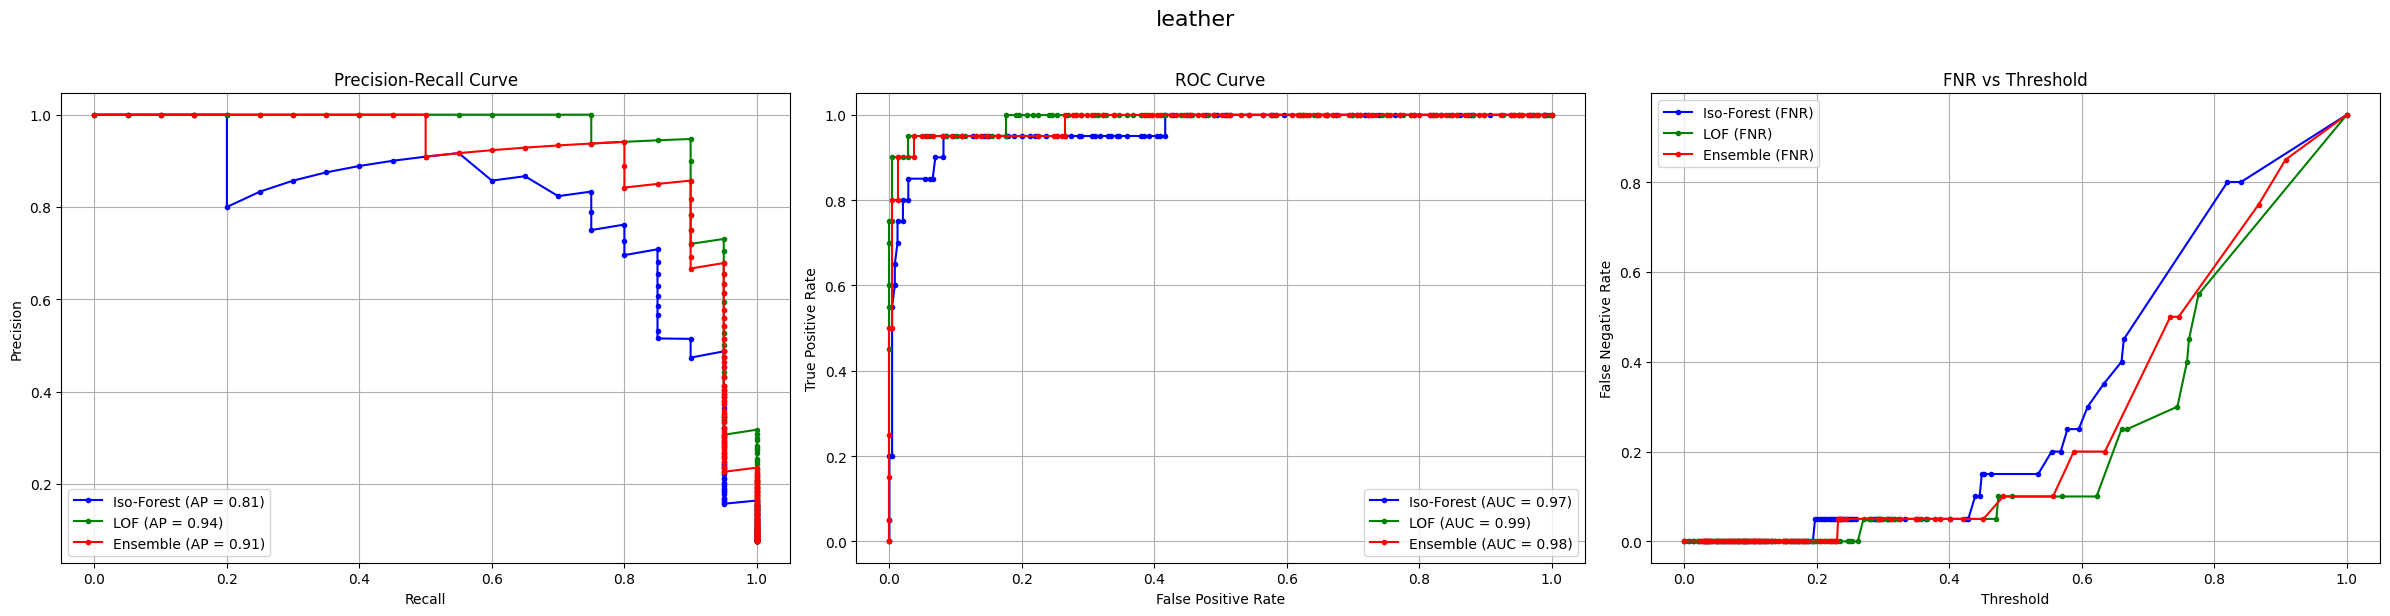

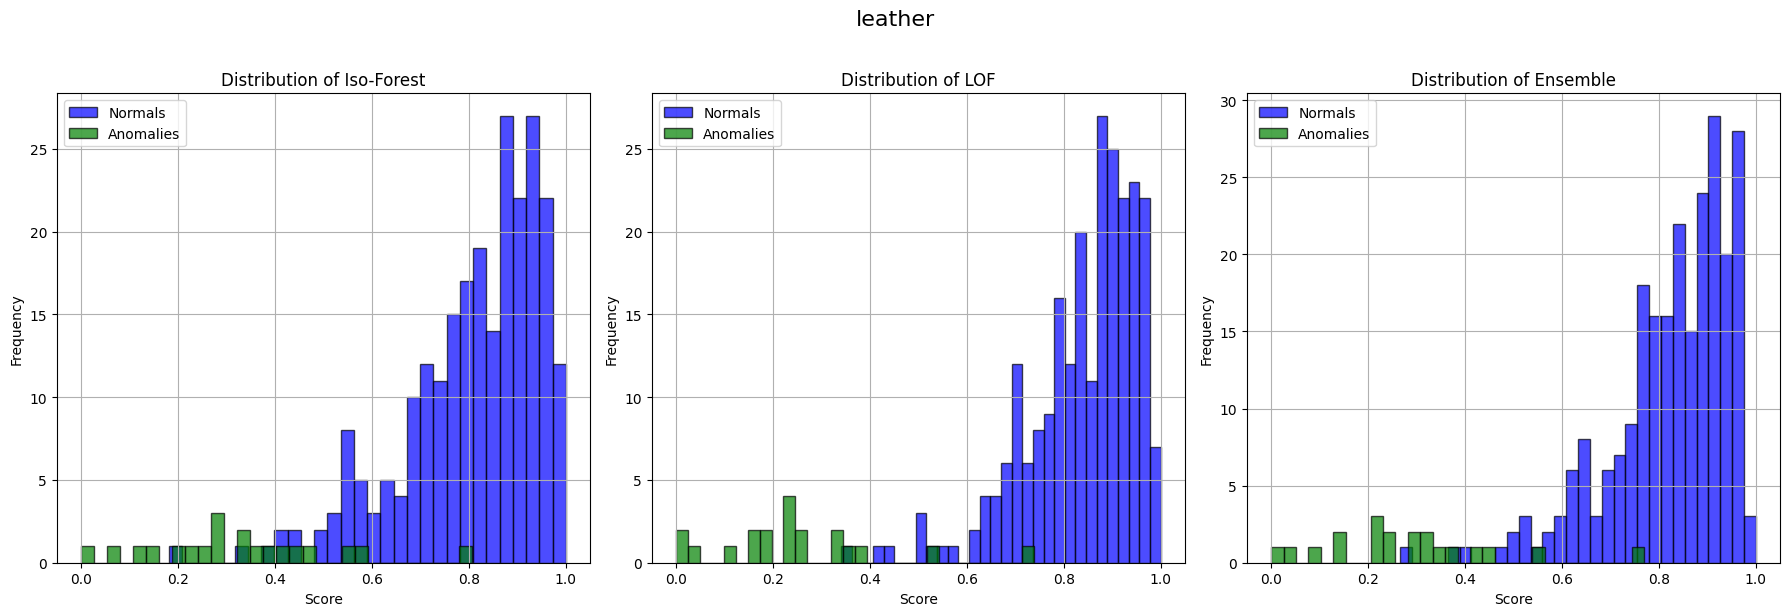

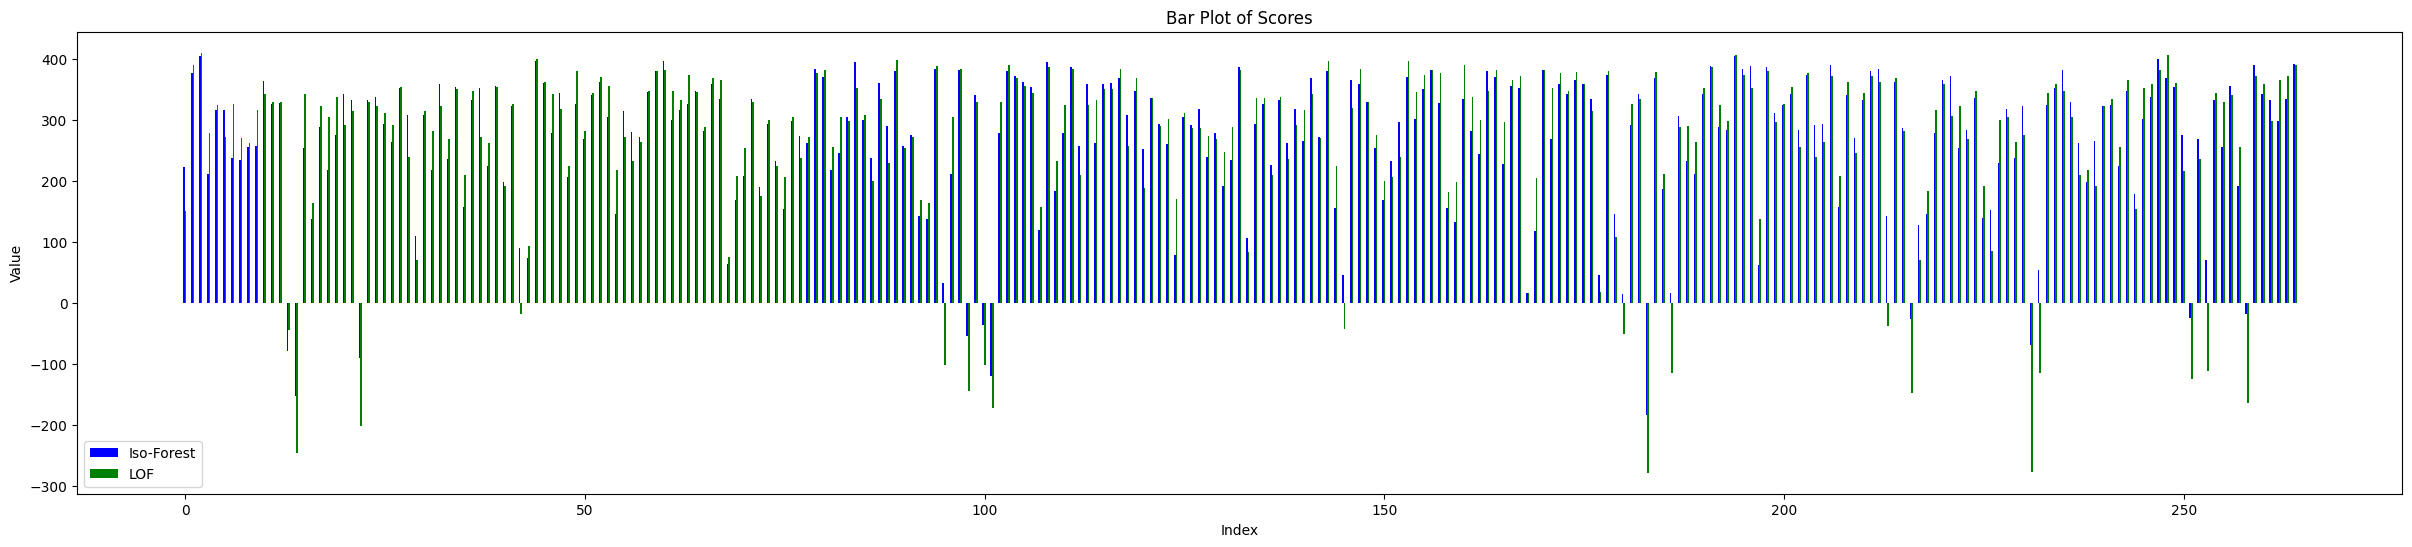

/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


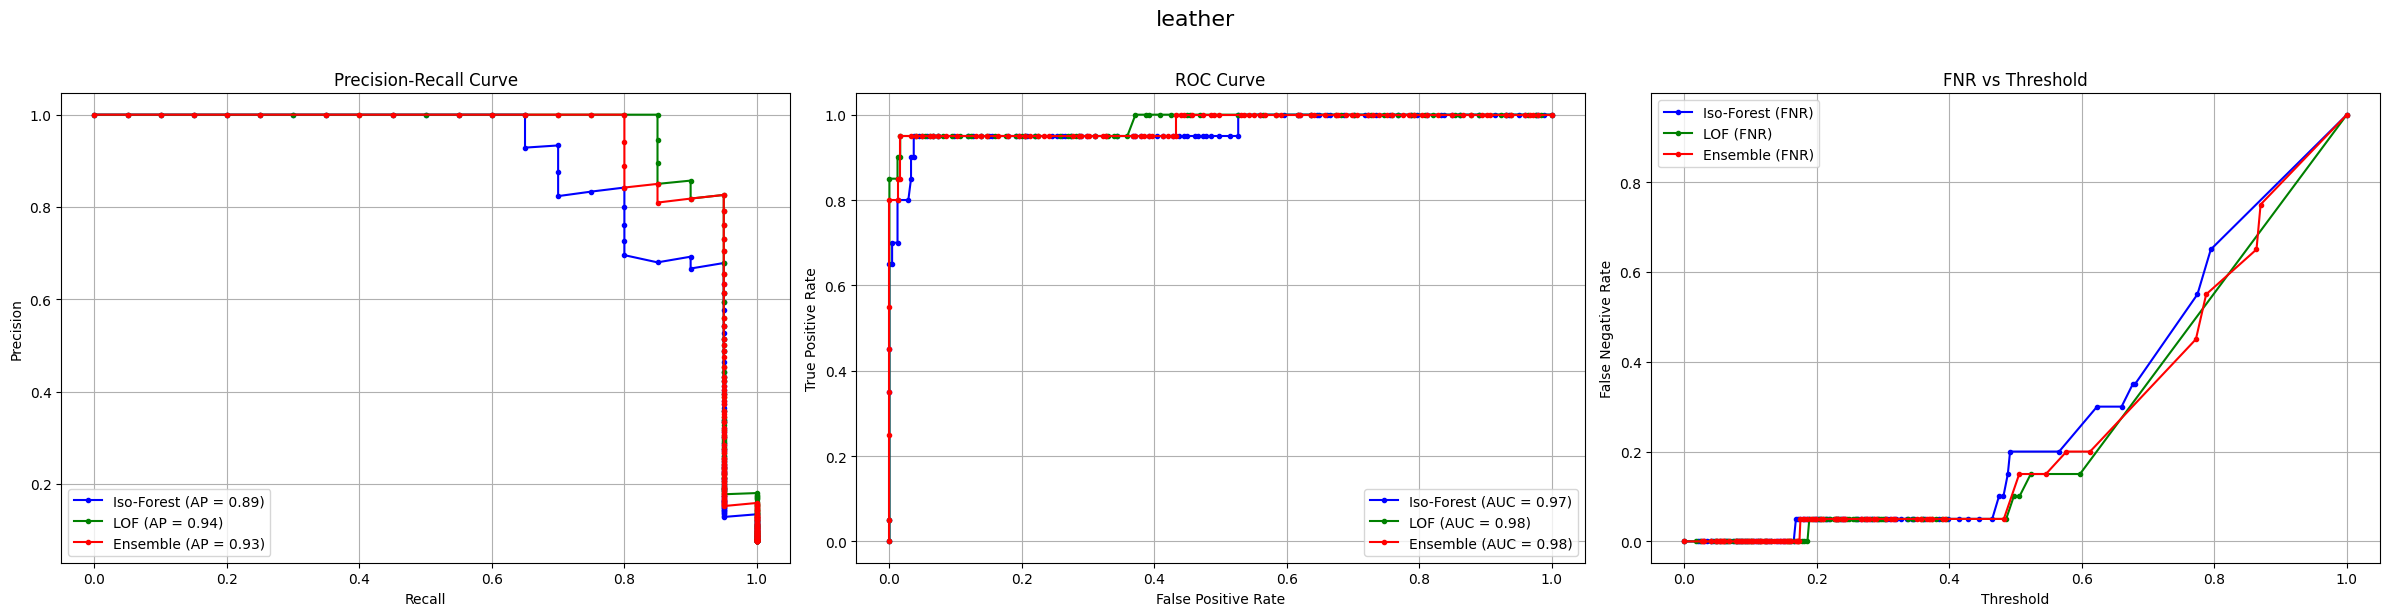

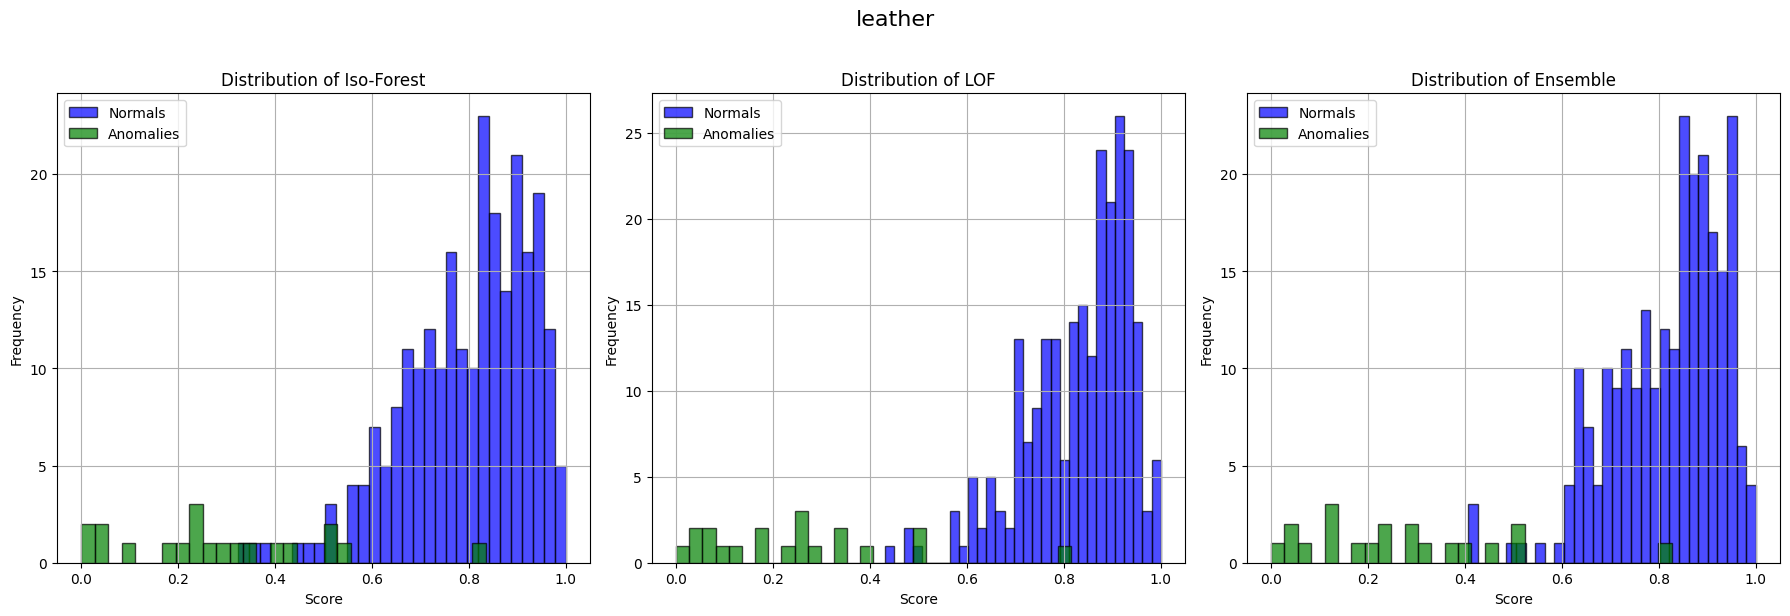

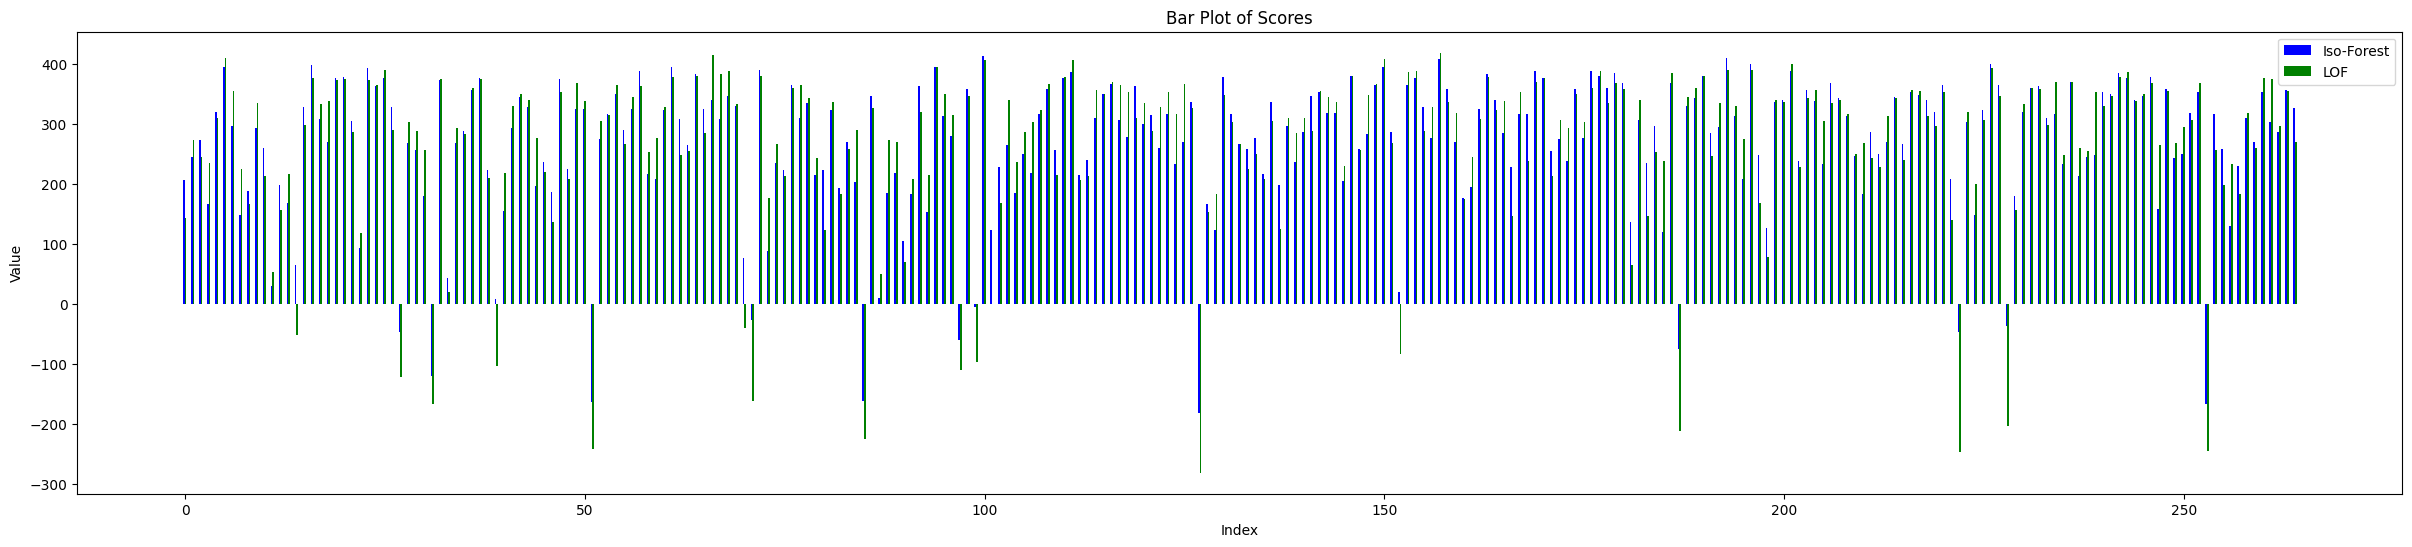

/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


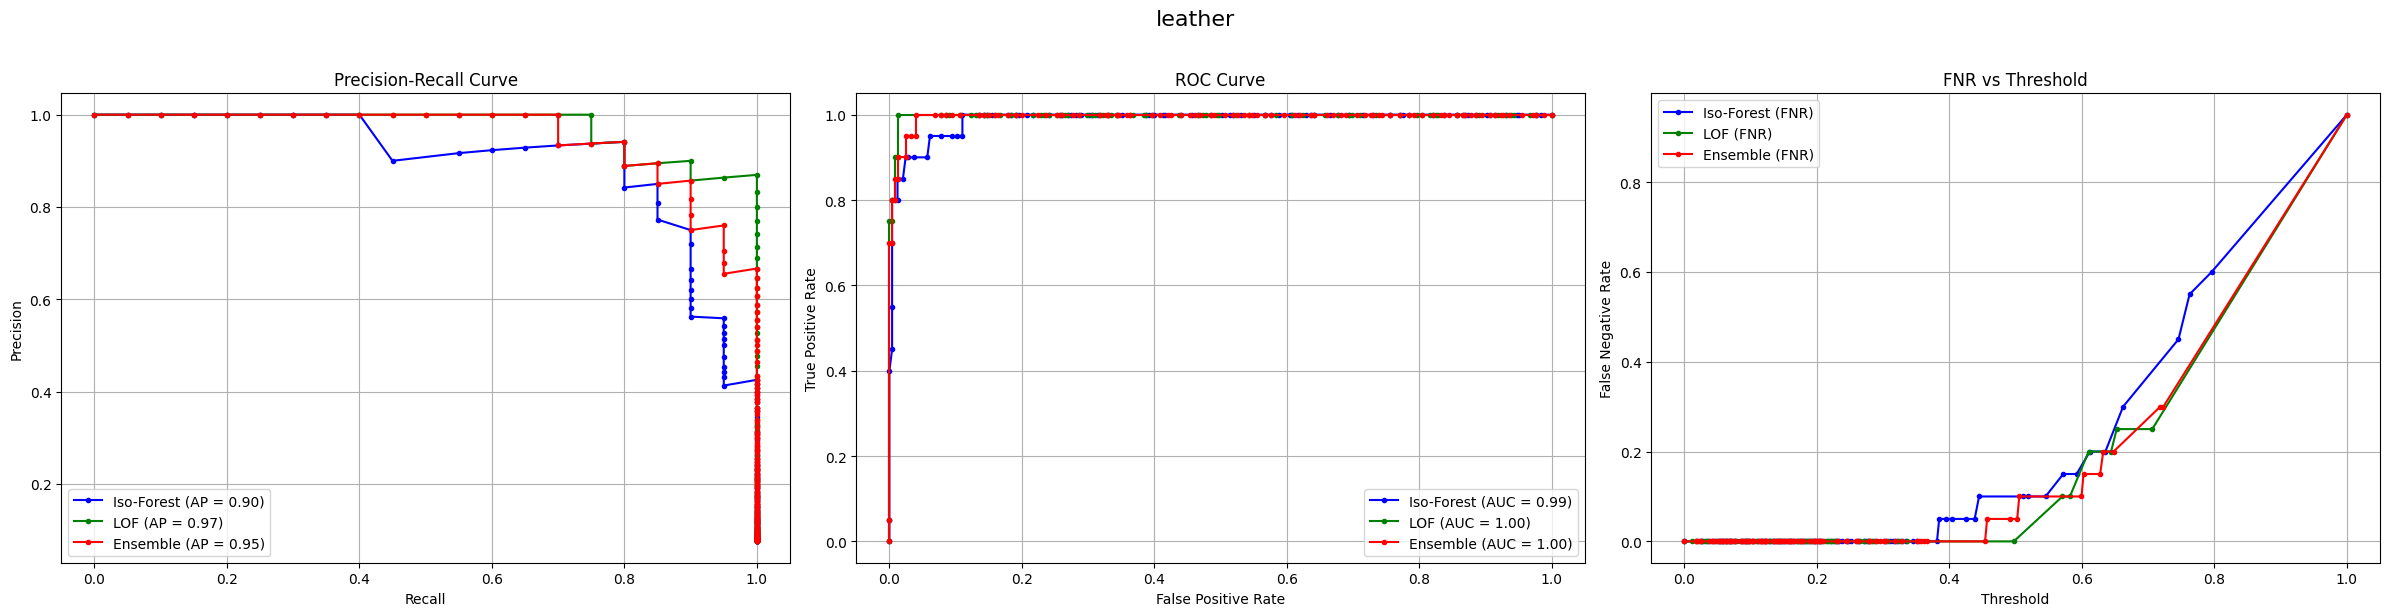

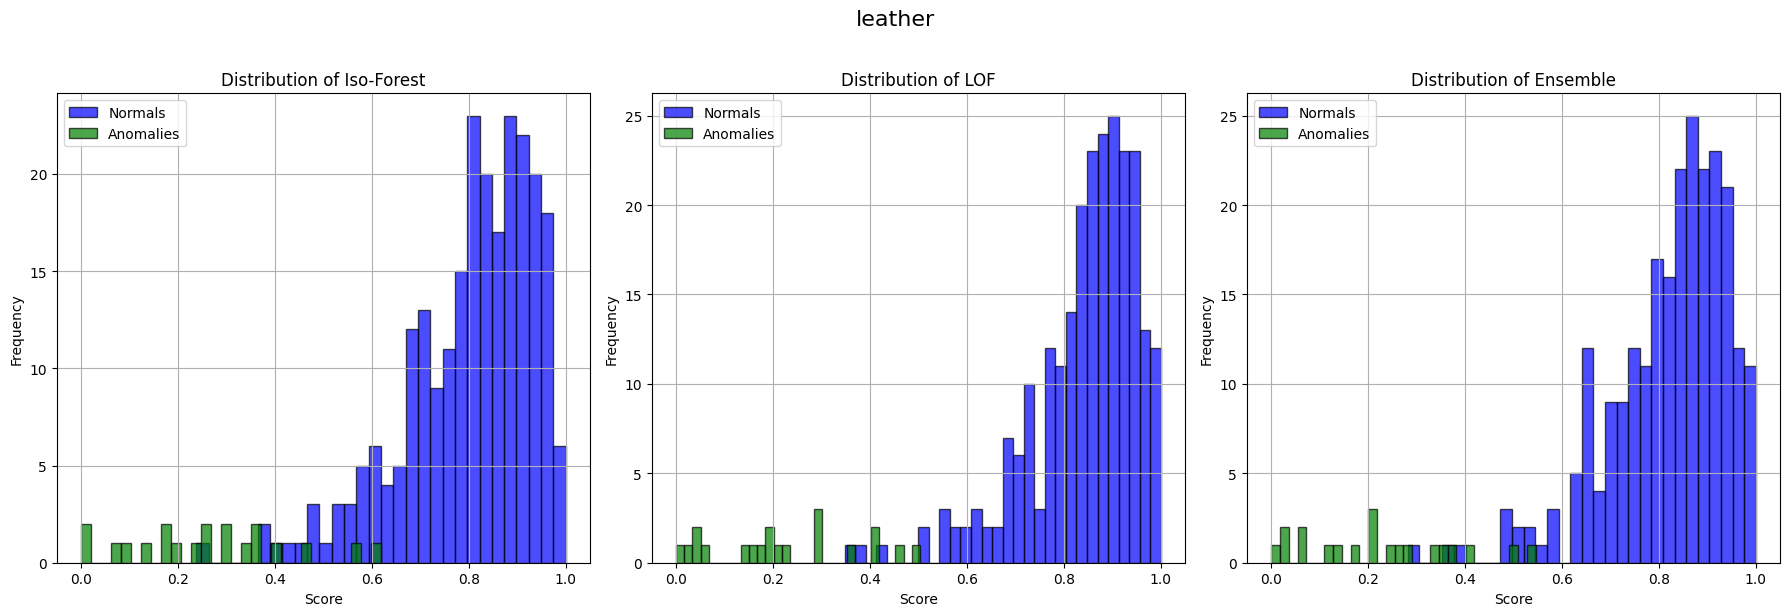

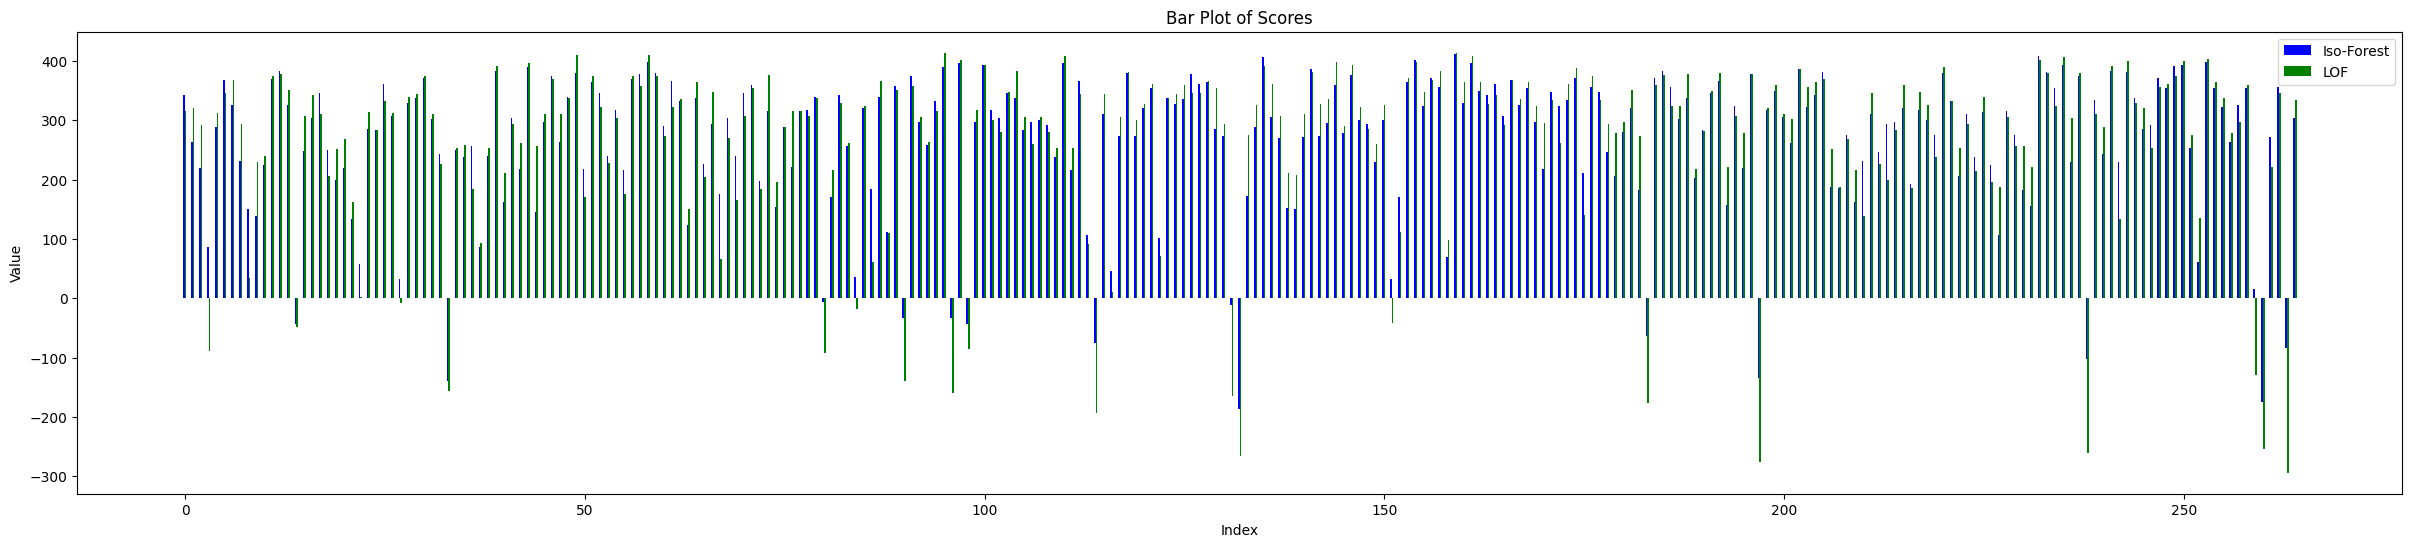

/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


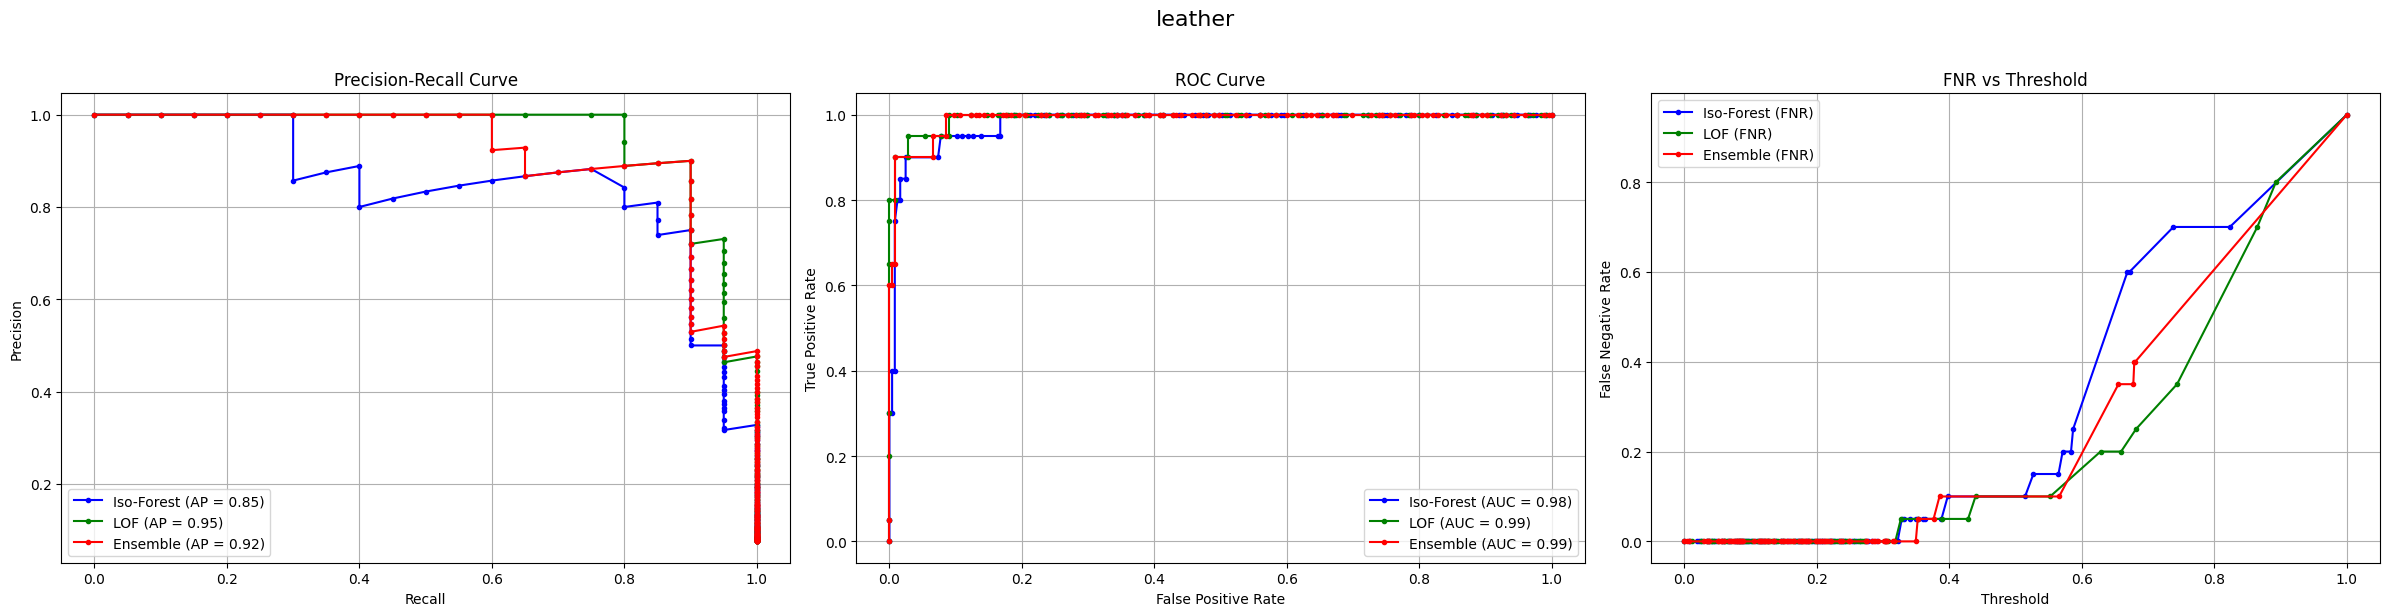

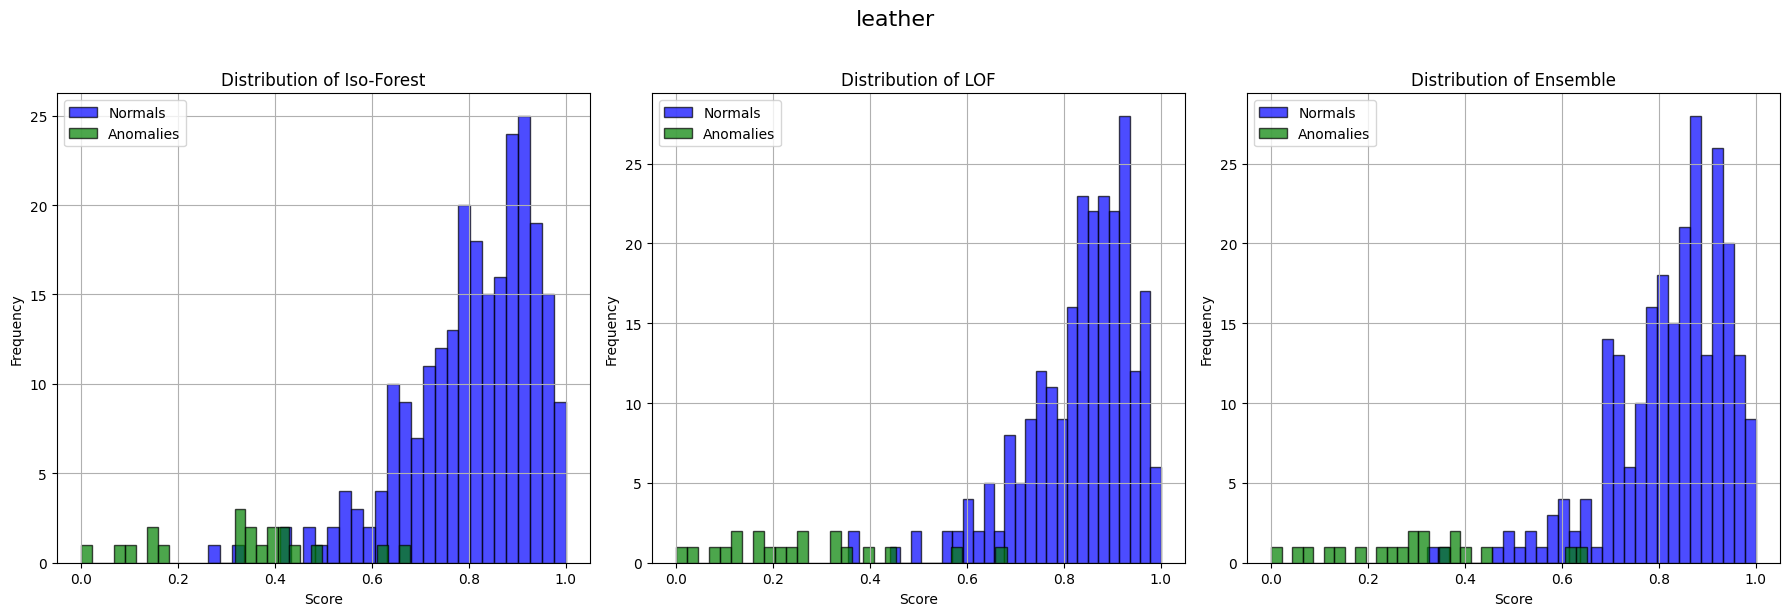

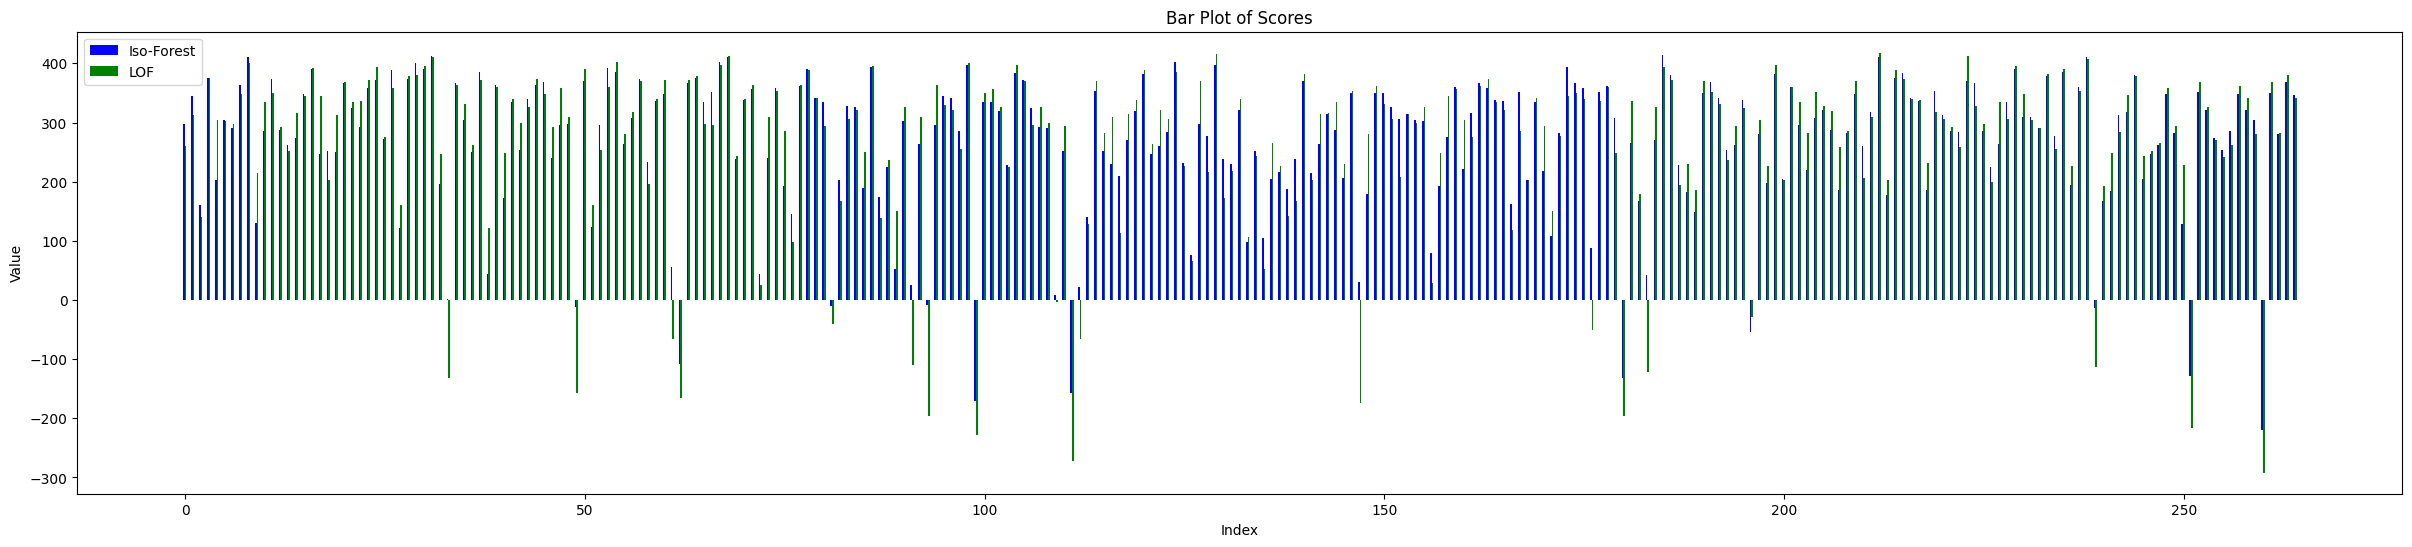

/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


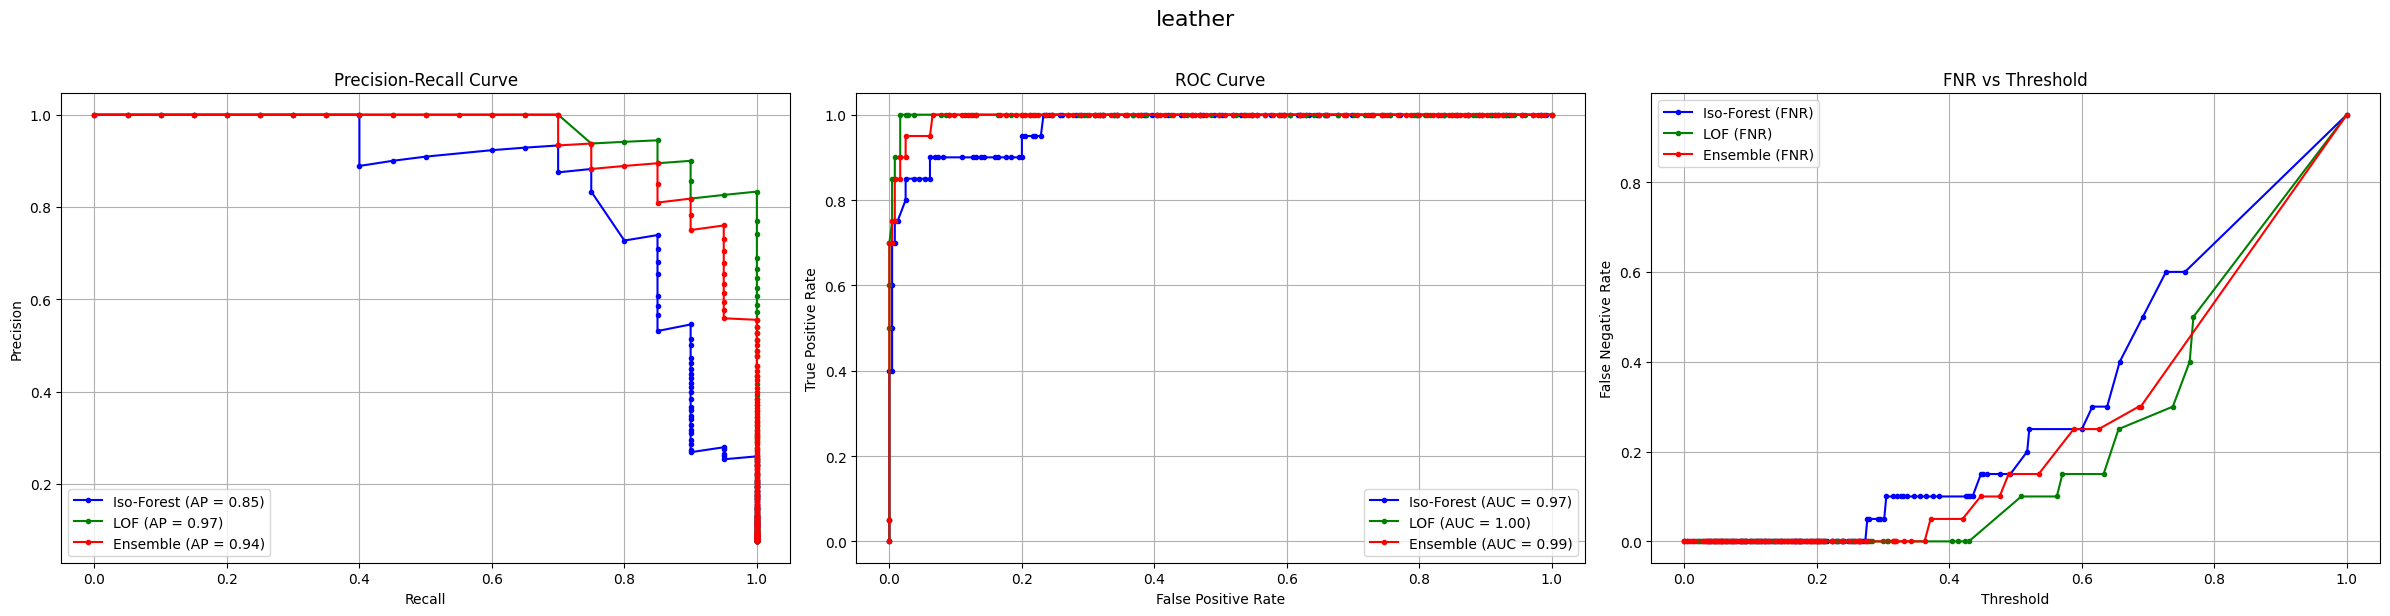

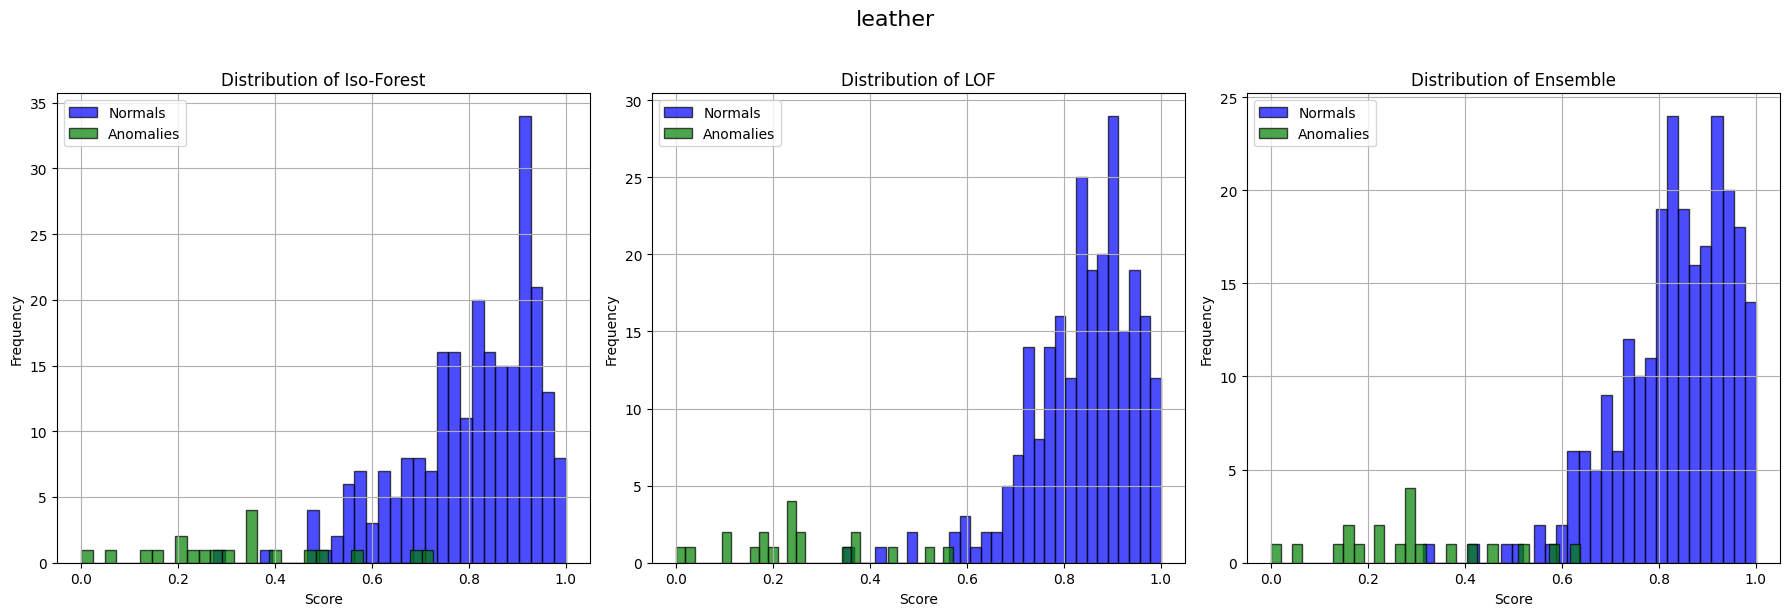

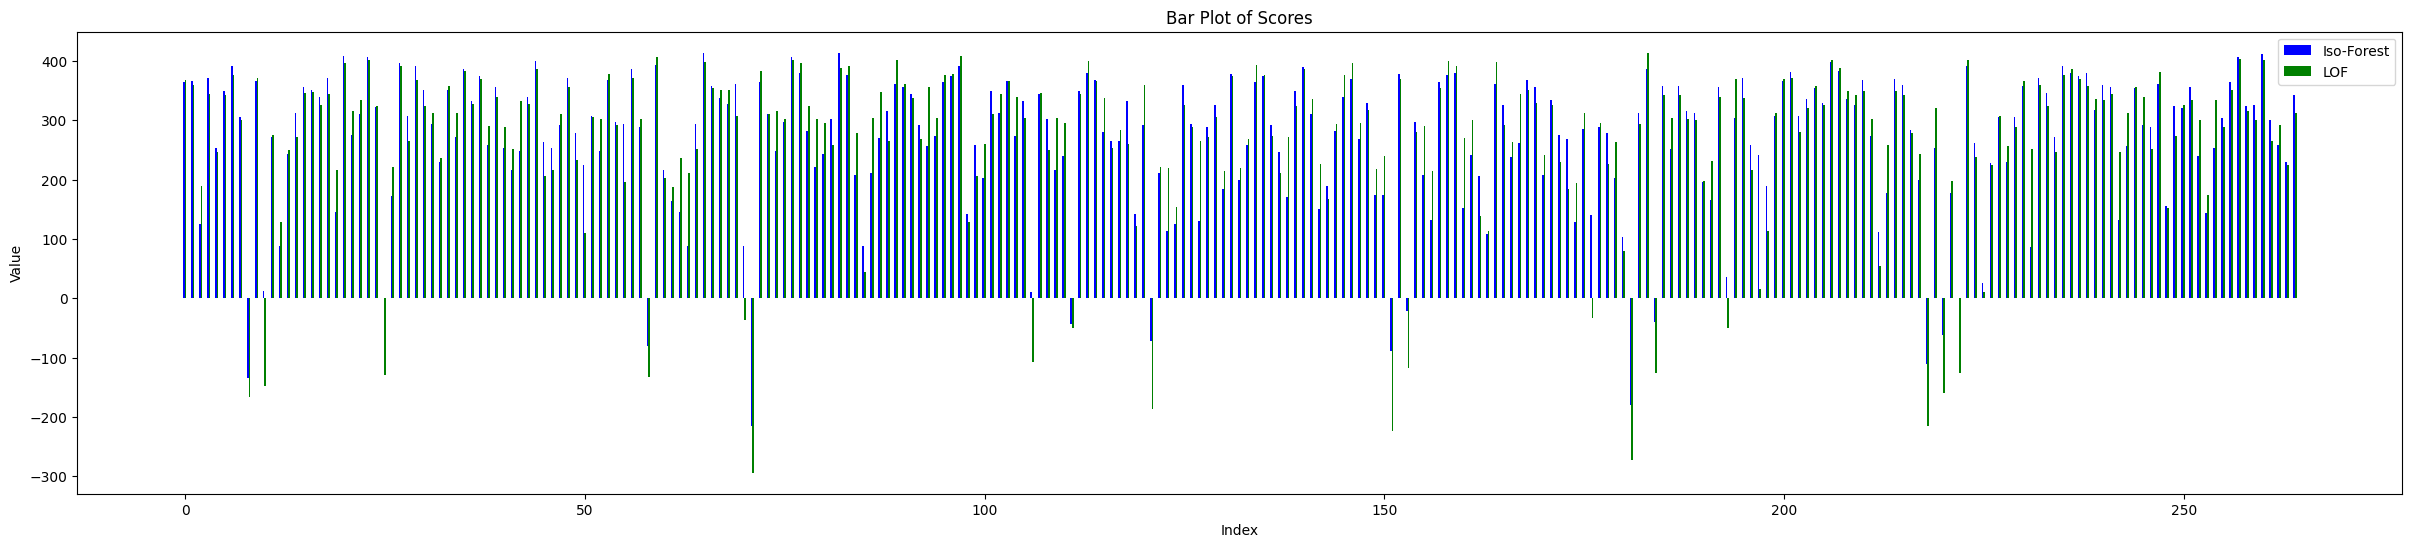

In [ ]:
category= "leather"

class TrainOptions:
    def __init__(self):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

args = TrainOptions()
torch.manual_seed(args.seed)





#run1
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_1-leather/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)

# run2
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_2-leather/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)

# run3
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_3-leather/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)

# run4
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_4-leather/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)

# run5
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_5-leather/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)



# CARPET

In [ ]:
category= "carpet"

class TrainOptions:
    def __init__(self):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

args = TrainOptions()
torch.manual_seed(args.seed)





#run1
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_1-carpet/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)

# run2
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_2-carpet/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)

# run3
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_3-carpet/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)

# run4
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_4-carpet/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)

# run5
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_5-carpet/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)

